In [1]:
import suite2p
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd
import re
import os
import glob
from natsort import natsorted
from multiprocessing import Pool
from joblib import Parallel, delayed
from pathlib import Path
import gc
gc.collect()
import importlib
import sys
from pathlib import Path
# Add the directory containing your script to the Python path
from suite2p import run_s2p

from scipy.signal import welch
from suite2p.extraction import dcnv as s2p_dcnv
import math
from typing import Iterable, Optional, Tuple
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns



sys.path.append(r'C:\Users\zhangl33\Projects\Project-SLMonlineControl\CodeAndPackages\PYsubfun')

# Now you can import your script as a module
import FastBin_Suite2p as FBS
import CalBin2p as CB
import SLM_Offline as slmO
import Suite2p_QualityControl as QC 

In [4]:
import Suite2p_QualityControl as QC 

In [17]:
data= loadmat(r'D:\Project1-LocalProcessing\Step1\11-Aug-2025FOV.mat')
FOV=data['FOVUpdate']
FOVsave=data['suite2pFOVPath']                    ##<<saved at local C:
#FOVref=data['suite2pFOVPath']                         ##<<saved at server
FOVref=data['suite2pFOVPath']                    ##<<saved at local C:



In [18]:
# Base folder
importlib.reload(CB)
base_path = r"\\nimhlabstore1.nimh.nih.gov\UFNC\FNC3Z\RawRecording\GCamP6S-CamKII"

FOVsave_updated=CB.find_all_folders_keywords(base_path, 'suite2p',2)
FOVsave_updated

['\\\\nimhlabstore1.nimh.nih.gov\\UFNC\\FNC3Z\\RawRecording\\GCamP6S-CamKII\\L00121\\09232025\\suite2p',
 '\\\\nimhlabstore1.nimh.nih.gov\\UFNC\\FNC3Z\\RawRecording\\GCamP6S-CamKII\\SL0855\\03042025\\suite2p',
 '\\\\nimhlabstore1.nimh.nih.gov\\UFNC\\FNC3Z\\RawRecording\\GCamP6S-CamKII\\SL0855\\03062025\\suite2p',
 '\\\\nimhlabstore1.nimh.nih.gov\\UFNC\\FNC3Z\\RawRecording\\GCamP6S-CamKII\\SL0864\\04142025\\suite2p',
 '\\\\nimhlabstore1.nimh.nih.gov\\UFNC\\FNC3Z\\RawRecording\\GCamP6S-CamKII\\SL0864\\04162025\\suite2p',
 '\\\\nimhlabstore1.nimh.nih.gov\\UFNC\\FNC3Z\\RawRecording\\GCamP6S-CamKII\\SL0864\\04222025\\suite2p',
 '\\\\nimhlabstore1.nimh.nih.gov\\UFNC\\FNC3Z\\RawRecording\\GCamP6S-CamKII\\SL0886\\04152025\\suite2p',
 '\\\\nimhlabstore1.nimh.nih.gov\\UFNC\\FNC3Z\\RawRecording\\GCamP6S-CamKII\\SL0886\\04252025\\suite2p',
 '\\\\nimhlabstore1.nimh.nih.gov\\UFNC\\FNC3Z\\RawRecording\\GCamP6S-CamKII\\SL0893\\04212025\\suite2p',
 '\\\\nimhlabstore1.nimh.nih.gov\\UFNC\\FNC3Z\\RawRecor

In [98]:
suite2pFOV = [os.path.join(fov, "combined") for fov in FOVsave_updated]
suite2pFOV

['\\\\nimhlabstore1.nimh.nih.gov\\UFNC\\FNC3Z\\RawRecording\\GCamP6S-CamKII\\L00121\\09232025\\suite2p\\combined',
 '\\\\nimhlabstore1.nimh.nih.gov\\UFNC\\FNC3Z\\RawRecording\\GCamP6S-CamKII\\SL0855\\03042025\\suite2p\\combined',
 '\\\\nimhlabstore1.nimh.nih.gov\\UFNC\\FNC3Z\\RawRecording\\GCamP6S-CamKII\\SL0855\\03062025\\suite2p\\combined',
 '\\\\nimhlabstore1.nimh.nih.gov\\UFNC\\FNC3Z\\RawRecording\\GCamP6S-CamKII\\SL0864\\04142025\\suite2p\\combined',
 '\\\\nimhlabstore1.nimh.nih.gov\\UFNC\\FNC3Z\\RawRecording\\GCamP6S-CamKII\\SL0864\\04162025\\suite2p\\combined',
 '\\\\nimhlabstore1.nimh.nih.gov\\UFNC\\FNC3Z\\RawRecording\\GCamP6S-CamKII\\SL0864\\04222025\\suite2p\\combined',
 '\\\\nimhlabstore1.nimh.nih.gov\\UFNC\\FNC3Z\\RawRecording\\GCamP6S-CamKII\\SL0886\\04152025\\suite2p\\combined',
 '\\\\nimhlabstore1.nimh.nih.gov\\UFNC\\FNC3Z\\RawRecording\\GCamP6S-CamKII\\SL0886\\04252025\\suite2p\\combined',
 '\\\\nimhlabstore1.nimh.nih.gov\\UFNC\\FNC3Z\\RawRecording\\GCamP6S-CamKII\\SL0

In [88]:


# Make sure heavy math libs don't oversubscribe threads
for k in ("OMP_NUM_THREADS","OPENBLAS_NUM_THREADS","MKL_NUM_THREADS","NUMEXPR_NUM_THREADS","BLIS_NUM_THREADS"):
    os.environ[k] = os.environ.get(k, "1")

module_paths = [os.path.dirname(slmO.__file__), os.path.dirname(QC.__file__)]

metrics_table, all_psd, failures = run_parallel(
    FOVsave_updated,
    backend="thread",              # <--- key change
    max_workers=min(8, os.cpu_count()),
    join_subdir="combined",
    module_paths=module_paths,
    env_threads=1,
)

print("metrics_table:", metrics_table.shape, "all_psd:", all_psd.shape)
if failures:
    print("\n--- Worker failures (threads) ---")
    for f in failures:
        print(f"[# {f['idx']}] {f['suite2pdir']}\n{f['traceback']}\n")




RuntimeError: All workers failed. See 'failures' for details.

In [89]:
# --- Option B: stand-alone process-pool smoke test script ---
# Save as test_process_pool.py and run from a terminal:  python test_process_pool.py

if __name__ == "__main__":
    import multiprocessing as mp
    from concurrent.futures import ProcessPoolExecutor
    import platform

    def hello(i):
        import os
        return f"child {i} pid={os.getpid()} on {platform.system()}"

    try:
        mp.set_start_method("spawn", force=True)
        with ProcessPoolExecutor(max_workers=2, mp_context=mp.get_context('spawn')) as ex:
            out = list(ex.map(hello, range(4)))
        print("Process pool OK:", out)
    except Exception as e:
        print("Process pool FAILED:", e)


Process pool FAILED: A process in the process pool was terminated abruptly while the future was running or pending.


In [90]:

# --- Option C: incremental import probe to find the crashing import ---
# Run this in a new file (probe_imports.py) to identify which import kills workers.
# Usage: python probe_imports.py

if __name__ == "__main__":
    from concurrent.futures import ProcessPoolExecutor
    import multiprocessing as mp

    modules_to_probe = [
        "numpy",
        "pandas",
        "scipy",
        "suite2p",
        "slmO",
        "QC",
    ]

    def try_import(mod):
        try:
            __import__(mod)
            return (mod, "OK")
        except Exception as e:
            return (mod, f"FAIL: {e}")

    mp.set_start_method("spawn", force=True)
    with ProcessPoolExecutor(max_workers=1, mp_context=mp.get_context('spawn')) as ex:
        results = list(ex.map(try_import, modules_to_probe))
    print(results)


BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

In [ ]:
## all awake with initial refImg defined in spontanous data
importlib.reload(slmO)
importlib.reload(QC)

FunColorValue = [0.0,0.0,0.0]

#ops0['threshold_scaling']=0.9
all_metrics = []

all_iscellZero=[]
all_psd = []
for i in range(0,len(FOVsave_updated)):
#for i in range(0,1):

    #full_save_path = os.path.join(FOVtempSave, folder_name)
    suite2pdir= os.path.join(FOVsave_updated[i],'combined')


    CaData=slmO.extract_suite2pNoPlane(suite2pdir)
    

    iscellManual=np.array(CaData['iscell'][:,0])
    iscell=np.array(CaData['iscell'][:,0])
    iscellZero=np.ones(len(iscell))
    statRaw=CaData['stat']
    #footprint=np.array([s.get('footprint') for s in statRaw])
    #mrs0=np.array([s.get('mrs0') for s in statRaw])
    #radius=np.array([s.get('radius') for s in statRaw])
    
    #iscellZero[footprint < 1]=0
    #iscellZero[mrs0 < 2]=0
    #iscellZero[radius < 3]=0
   
    
    
    df_metrics = QC.extract_metrics_from_stat(statRaw, iscellManual, suite2pdir)

    snr, sigma_psd, A_evt, psdPerc,fre = QC.compute_snr_with_suite2p_preprocess(
        CaData,
        nperseg=512,
        fband=(2, 3.3),   # near Nyquist for fs=10
        amp_method="sum",
        min_event_snr=4,          # events must exceed this many sigmas to count
        amp_percentile=0.5,         # robust high-quantile across events
        eps=20,
        recompute_spks=True
    )
    # then add snr, sigma_psd, A_evt as new columns to df_metrics
    
    #iscellZero[snr < 0.1]=0
    #df_metrics = QC.extract_metrics_from_stat(statRaw, iscellZero, suite2pdir)

    #df_metrics = QC.extract_metrics_from_stat(statRaw, iscellZero, FOVtempSave)
    # Attach to the metrics table (ROI order must match your stat/iscell build)
    df_metrics['A_evt']        = A_evt
    df_metrics['sigma_psd']    = sigma_psd
    df_metrics['snr_oasis_evt']= snr

    

    #df_metricsManual['A_evt']        = A_evt
    #df_metricsManual['sigma_psd']    = sigma_psd
    #df_metricsManual['snr_oasis_evt']= snr
    #df_metrics['fs_used']      = snr_meta['fs']
   # df_metrics['band_lo']      = snr_meta['band'][0]
    #df_metrics['band_hi']      = snr_meta['band'][1]
    
    
    all_psd.append(psdPerc)
    all_metrics.append(df_metrics)
    #all_metricsManual.append(df_metricsManual)
# Combine into one big table
metrics_table = pd.concat(all_metrics, ignore_index=True)
#metrics_tableManual = pd.concat(all_metricsManual, ignore_index=True)
all_psd = np.vstack(all_psd)



In [111]:
from __future__ import annotations
import os
from typing import Mapping, Any, Tuple

import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

# Default parameters
default_params = {
    "nperseg": 512,
    "low_band": (0.2, 1.6),
    "high_band": (2.5, 3.3),
    "amp_method": "sum",
    "min_event_snr": 4,
    "amp_percentile": 0.5,
    "eps": 10,
    "recompute_spks": True,
}


def process_one_folder(suite2pdir: str, params: Mapping[str, Any] | None) -> Tuple[pd.DataFrame, np.ndarray, np.ndarray]:
    """
    Process a single Suite2p folder and return metrics.

    Returns
    -------
    df_metrics : pandas.DataFrame
    psd : np.ndarray (n_cells, n_freqs)
    fre : np.ndarray (n_freqs,)
    """
    cfg = {**default_params, **(dict(params) if params else {})}

    # --- Load Suite2p outputs ---
    CaData = slmO.extract_suite2pNoPlane(suite2pdir)
    iscell_manual = np.asarray(CaData["iscell"][:, 0])
    stat_raw = CaData["stat"]

    # --- Base metrics ---
    df_metrics = QC.extract_metrics_from_stat(stat_raw, iscell_manual, suite2pdir)

    # --- SNR/PSD metrics ---
    snr, sigma_psd, A_evt, psd, fre = QC.compute_snr_with_suite2p_preprocess(
        CaData,
        nperseg=cfg["nperseg"],
        fband=cfg["high_band"],
        amp_method=cfg["amp_method"],
        min_event_snr=cfg["min_event_snr"],
        amp_percentile=cfg["amp_percentile"],
        eps=cfg["eps"],
        recompute_spks=cfg["recompute_spks"],
    )

    # Attach metrics
    df_metrics["A_evt"] = A_evt
    df_metrics["sigma_psd"] = sigma_psd
    df_metrics["snr_oasis_evt"] = snr
    

    # --- Low/High Ratio (LHR) ---
    # If shape mismatch, automatically interpolate PSD to match fre length
    if psd.shape[1] != fre.shape[0]:
        x_old = np.linspace(0, 1, psd.shape[1])
        x_new = np.linspace(0, 1, fre.shape[0])
        interp_func = interp1d(x_old, psd, kind="linear", axis=1, fill_value="extrapolate")
        psd = interp_func(x_new)

    df_metrics["LHR"] = QC.low_high_ratio(psd, fre, cfg["low_band"], cfg["high_band"])

    return df_metrics, psd, fre


__all__ = ["process_one_folder", "default_params"]

In [101]:
DEFAULT_PARAMS = {
    "nperseg": 512,
    "low_band": (0.2, 1.6),
    "high_band": (2.5, 3.3),
    "amp_method": "sum",
    "min_event_snr": 4,
    "amp_percentile": 0.5,
    "eps": 20,
    "recompute_spks": True,
}
params = {**DEFAULT_PARAMS, "low_band": (0.2, 1.6), "high_band": (2.5, 3.3)}

In [112]:
df_metrics, psdPerc, fre = process_one_folder(suite2pFOV[0], params)

6.9
0.7
60.0
20.0


In [113]:
psdPerc.shape

(638, 257)

In [61]:
low_band=[0.2, 1.6]
high_band=[2.5, 3.3]
#QC.low_high_ratio(np.array(all_psd),fre,low_band,high_band)
metrics_table["LHR"]=QC.low_high_ratio(np.array(all_psd),fre,low_band,high_band)

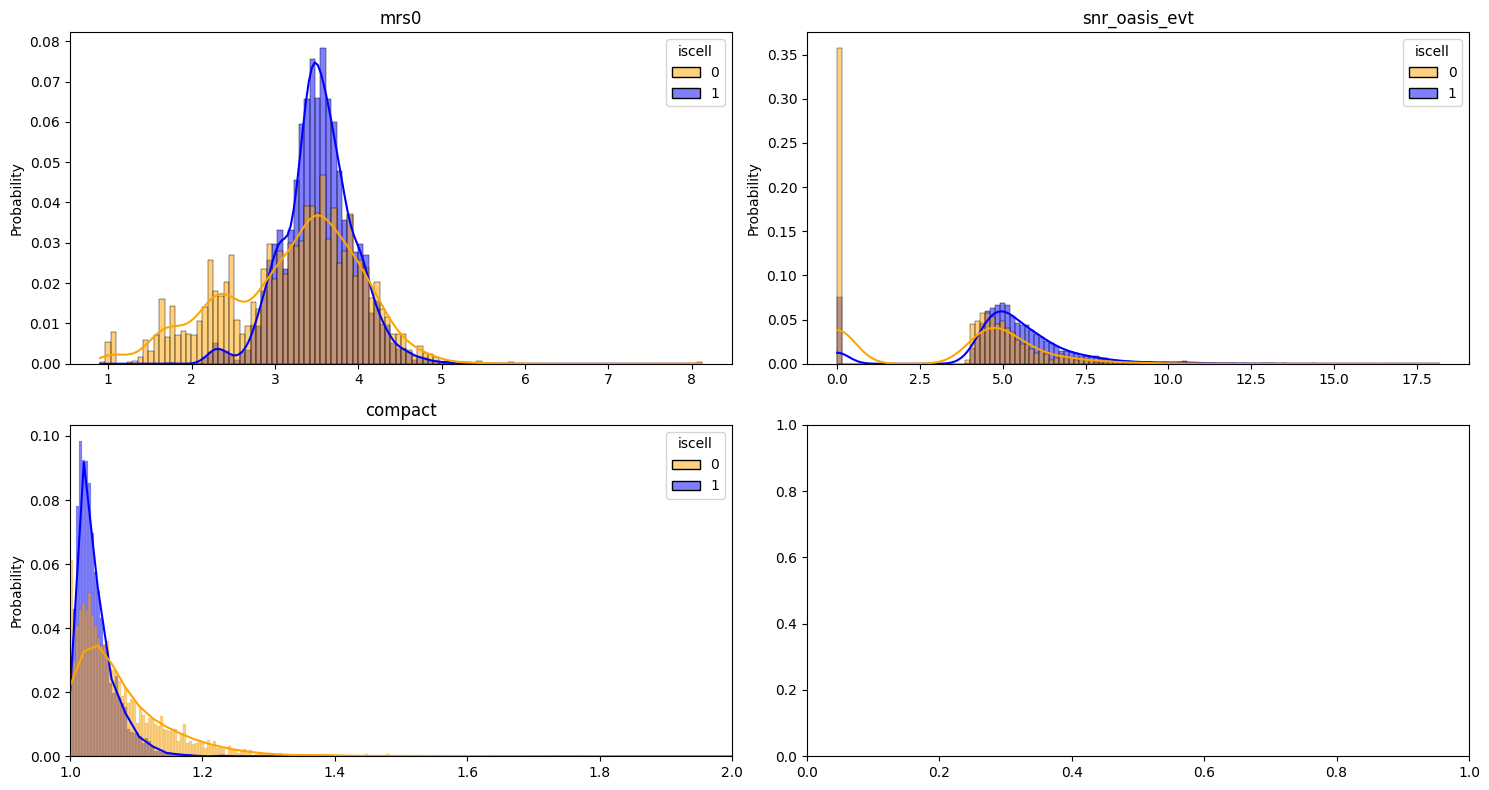

In [66]:
metrics_subset = ['mrs0','snr_oasis_evt','compact']

ncols = int(np.ceil(len(metrics_subset) / 2))   # columns needed
fig, axes = plt.subplots(2, ncols, figsize=(15, 8))  
axes = axes.flatten()

for idx, col in enumerate(metrics_subset):
    ax = axes[idx]
    sns.histplot(
        data=metrics_table,
        x=col,
        hue='iscell',
        hue_order=[0, 1],
        stat='probability',
        common_norm=False,
        kde=True,
        palette={0: "orange", 1: "blue"},
        alpha=0.5,
        ax=ax
    )
    ax.set_title(col)
    #ax.set_ylabel("Count")
    ax.set_xlabel("")
    if col == "LHR":
       ax.set_xlim(0, 2)   # adjust upper limit depending on your data spread
    if col == "compact":
       ax.set_xlim(1, 2)   # adjust upper limit depending on your data spread       
#    
plt.tight_layout()
plt.show()

In [21]:
# Save the distributions PDF for the filtered rows
out = QC.save_metric_distributions_pdf(
    metrics_table=metrics_table,
    iscell=metrics_table.iscell,
    pdf_path=r"\\nimhlabstore1.nimh.nih.gov\UFNC\FNC3Z\RawRecording\GCamP6S-CamKII\metrics_distributionsCounts.pdf",
    probability=False,
)
print("Saved to:", out)


Saved to: \\nimhlabstore1.nimh.nih.gov\UFNC\FNC3Z\RawRecording\GCamP6S-CamKII\metrics_distributionsCounts.pdf


In [23]:
# Subset the metrics table
metrics_table_sub = metrics_table.loc[
    (metrics_table['footprint'] > 0.1) &
    (metrics_table['mrs0'] > 2.5)
].copy()
out = QC.save_metric_distributions_pdf(
    metrics_table=metrics_table_sub,
    iscell=metrics_table_sub.iscell,
    pdf_path=r"\\nimhlabstore1.nimh.nih.gov\UFNC\FNC3Z\RawRecording\GCamP6S-CamKII\metrics_distributionsFootPrintmrs0ExcCounts.pdf",
    probability=False,
)

print("Saved to:", out)

Saved to: \\nimhlabstore1.nimh.nih.gov\UFNC\FNC3Z\RawRecording\GCamP6S-CamKII\metrics_distributionsFootPrintmrs0ExcCounts.pdf


In [63]:
print(np.sum(metrics_table_sub.iscell==1))
print(np.sum(metrics_table_sub.iscell==0))

3968
526


In [54]:
# Subset the metrics table
metrics_table_sub = metrics_table.loc[
    (metrics_table['footprint'] > 0.1) &
    (metrics_table['snr_oasis_evt'] > 1) &
    (metrics_table['mrs0'] > 2.5)
].copy()
out = QC.save_metric_distributions_pdf(
    metrics_table=metrics_table_sub,
    iscell=metrics_table_sub.iscell,
    pdf_path=r"\\nimhlabstore1.nimh.nih.gov\UFNC\FNC3Z\RawRecording\GCamP6S-CamKII\metrics_distributionsFootPrintmrs0ExcSNRCounts.pdf",
    probability=False,
)

print("Saved to:", out)

Saved to: \\nimhlabstore1.nimh.nih.gov\UFNC\FNC3Z\RawRecording\GCamP6S-CamKII\metrics_distributionsFootPrintmrs0ExcSNRCounts.pdf


In [59]:

metrics_table_sub = metrics_table.loc[
    (metrics_table['footprint'] > 0.1) &
    (metrics_table['snr_oasis_evt'] > 1) &
    (metrics_table['mrs0'] > 2.5) &
    (metrics_table['compact'] < 1.1)
].copy()
out = QC.save_metric_distributions_pdf(
    metrics_table=metrics_table_sub,
    iscell=metrics_table_sub.iscell,
    pdf_path=r"\\nimhlabstore1.nimh.nih.gov\UFNC\FNC3Z\RawRecording\GCamP6S-CamKII\metrics_distributionsFootPrintmrs0ExcSNRCompactCounts.pdf",
    probability=False,
)

print("Saved to:", out)










Saved to: \\nimhlabstore1.nimh.nih.gov\UFNC\FNC3Z\RawRecording\GCamP6S-CamKII\metrics_distributionsFootPrintmrs0ExcSNRCompactCounts.pdf


In [56]:

ConfigFolder=r'C:\Users\zhangl33\Projects\Project-SLMonlineControl\config'
ops0, confSet=FBS.configLoad(ConfigFolder,'SLMsetting.yml','ops3PlanesG6.npy')
ops0['spatial_scale']=2
ops0['threshold_scaling']=0.9
ops0['denoise']=0
ops0['tau']=1.5
ops0['look_one_level_down']=False               ##This is important as the subfolders is defined in db
ops0['combined']=True



In [277]:
iscellM=np.array(metrics_tableManual.iscell)
print(sum(iscellM))
ZeroAuto=np.ones(len(iscellM))
print(sum(ZeroAuto))

ZeroAuto[np.array((metrics_table.footprint < 1) | (metrics_table.mrs0 < 2)| (metrics_table.snr_oasis_evt < 0.1))]=0
#ZeroAuto[np.array( (metrics_table.mrs0 > 2)&(metrics_table.snr_oasis_evt > 0.1))]=1
print(sum((iscellM-ZeroAuto)>0.1)/len(iscellM))  #False reject
print(sum((iscellM-ZeroAuto)<-0.1)/len(iscellM)) #False positive

5360
6187.0
0.016647809924034265
0.047680620656214645


In [290]:
iscellM=np.array(metrics_tableManual.iscell)
print(sum(iscellM))
ZeroAuto=np.ones(len(iscellM))
print(sum(ZeroAuto))

#ZeroAuto[np.array((metrics_table.footprint > 0) & (metrics_table.mrs0 > 2))]=1
#ZeroAuto[np.array( (metrics_table.mrs0 > 2)&(metrics_table.snr_oasis_evt > 0.1))]=1
print(sum((iscellM-ZeroAuto)>0.1)/len(iscellM))  #False reject
print(sum((iscellM-ZeroAuto)<-0.1)/len(iscellM)) #False positive

5360
6187.0
0.0
0.13366736705996443


In [389]:
iscellM=np.array(metrics_tableManual.iscell)
# iscellM: ground truth (1 = real cell, 0 = not a cell)
# ZeroAuto: automatic judgement (1 = predicted cell, 0 = predicted not cell)
ZeroAuto=np.ones(len(iscellM))
#ZeroAuto[np.array((metrics_table.footprint < 1) | (metrics_table.mrs0 < 2)|(metrics_table.snr_oasis_evt < 0.1))]=0
#ZeroAuto[np.array((metrics_table.footprint > 0)& (metrics_table.mrs0 > 1.5)&(metrics_table.snr_oasis_evt > 1))]=1
#ZeroAuto[np.array((metrics_table.footprint < 1) | (metrics_table.mrs0 < 2))]=0
ZeroAuto[np.array(metrics_table.footprint < 1)]=0
#ZeroAuto[np.array(metrics_table.mrs0 < 1.5)]=0
#ZeroAuto[np.array(metrics_table.radius < 2)]=0
#ZeroAuto[np.array(metrics_table.snr_oasis_evt < 0.5)]=0
#ZeroAuto[np.array(metrics_table.compact > 1.2)]=0
#ZeroAuto[np.array(metrics_table.mrs0 < 1.5)]=0

iscellM = np.array(iscellM).astype(int)
ZeroAuto = np.array(ZeroAuto).astype(int)


# False negatives (missed real cells)
false_neg = np.sum((iscellM == 1) & (ZeroAuto == 0))
#print((iscellM == 1) & (ZeroAuto == 0))
total_neg = np.sum(ZeroAuto == 0)
false_reject_rate = false_neg / total_neg


# False positives (wrongly predicted cells)
false_pos = np.sum((iscellM == 0) & (ZeroAuto == 1))
total_pos = np.sum(ZeroAuto == 1)
false_positive_rate = false_pos / total_pos


print("False rejection rate (missed real cells):", false_reject_rate)
print("False positive rate (non-cells predicted as cells):", false_positive_rate)

False rejection rate (missed real cells): 0.08113590263691683
False positive rate (non-cells predicted as cells): 0.06568317527221637


In [357]:
iscellM=np.array(metrics_tableManual.iscell)
# iscellM: ground truth (1 = real cell, 0 = not a cell)
# ZeroAuto: automatic judgement (1 = predicted cell, 0 = predicted not cell)
ZeroAuto=np.zeros(len(iscellM))
#ZeroAuto[np.array((metrics_table.footprint < 1) | (metrics_table.mrs0 < 2)|(metrics_table.snr_oasis_evt < 0.1))]=0
#ZeroAuto[np.array((metrics_table.footprint > 0)& (metrics_table.mrs0 > 1.5)&(metrics_table.snr_oasis_evt > 1))]=1
#ZeroAuto[np.array((metrics_table.footprint < 1) | (metrics_table.mrs0 < 2))]=0
#ZeroAuto[np.array((metrics_table.footprint < 1)|(metrics_table.mrs0 < 1))]=0
#ZeroAuto[np.array((metrics_table.footprint > 0) & (metrics_table.mrs0 > 1.5) & (metrics_table.mrs0 > 0.1))] = 1
ZeroAuto[np.array((metrics_table.footprint > 0) & (metrics_table.mrs0 > 1.5) & (metrics_table.mrs0 > 0.1) & (metrics_table.npix_norm>0.4))] = 1
#ZeroAuto[np.array((metrics_table.footprint < 1)|(metrics_table.snr_oasis_evt < 0.05))]=0
#ZeroAuto[np.array(metrics_table.mrs0 < 1.5)]=0

iscellM = np.array(iscellM).astype(int)
ZeroAuto = np.array(ZeroAuto).astype(int)


# False negatives (missed real cells)
false_neg = np.sum((iscellM == 1) & (ZeroAuto == 0))
#print((iscellM == 1) & (ZeroAuto == 0))
total_neg = np.sum(ZeroAuto == 0)
false_reject_rate = false_neg / total_neg


# False positives (wrongly predicted cells)
false_pos = np.sum((iscellM == 0) & (ZeroAuto == 1))
total_pos = np.sum(ZeroAuto == 1)
false_positive_rate = false_pos / total_pos


print("False rejection rate (missed real cells):", false_reject_rate)
print("False positive rate (non-cells predicted as cells):", false_positive_rate)

False rejection rate (missed real cells): 0.24570673712021135
False positive rate (non-cells predicted as cells): 0.04714548802946593


In [217]:
sum(abs(metrics_table.iscell-metrics_tableManual.iscell))/len(metrics_tableManual.iscell)

0.0667528689187005

In [216]:
sum((metrics_table.iscell-metrics_tableManual.iscell)>0.1)/len(metrics_tableManual.iscell)

0.04622595765314369

In [215]:
sum((metrics_table.iscell-metrics_tableManual.iscell)<-0.1)/len(metrics_tableManual.iscell)

0.02052691126555681

In [432]:
## all awake with initial refImg defined in spontanous data
importlib.reload(slmO)
importlib.reload(QC)
RefKeyword = ['Spon']
FunColorValue = [0.0,0.0,0.0]
sucTable = []
DistTh=10
ops0['threshold_scaling']=0.9

all_metrics = []
all_metricsManual = []
all_iscellZero=[]
all_psd = []
for i in range(0,FOV.shape[1]):
#for i in range(0,1):
    FOVtemp = FOV[0, i]
    FOVtempSave=FOVsave[0,i]
    #print(FOVtempSave)
    FOVtempRef = FOVref[0,i]
    dfTemp=dfs[i]
    #print(FOVtemp['DataFolder'])   # or whatever field you want
    ops0['data_path']=FOVtemp['DataFolder']
    #ops0['save_path0']=r'E:/LuSLMOnlineTest/SL0855-Emx1G6CII-AAV9CAMKII/03042025/SingleP/Top44SpeedStimEdgeExc/Data/'
    file_ids = dfTemp.loc[dfTemp['AwakeState'] < 2,'FileID']   
    TiffNum = dfTemp.loc[dfTemp['AwakeState'] < 2, 'Suite2pTiffNum']
    #print(TiffNum.sum(),' tiff files')
    subFileRange = (file_ids.min(), file_ids.max())
    root     = Path(ops0['data_path'][0])
    folder_name = f"sub{subFileRange[0]}-{subFileRange[1]}awakeRef{RefKeyword[0]}"
    full_save_path = os.path.join(FOVtempSave[0], folder_name)
    #print(full_save_path)
    #full_save_path = os.path.join(FOVtempSave, folder_name)
    suite2pdir= os.path.join(full_save_path, 'suite2p')
    #print(suite2pdir)
    confdir=root.parent.parent.parent
    #FilteredPos3D, FilteredFunScore, FilteredTestPos3D, FilteredTestTBL = slmO.load_slm_data(root.parent)
    confSet=FBS.read_yaml(os.path.join(confdir,'CurrentSLMsetting.yml'))

    
    
    
    names, pairs = slmO.subfolders_and_pairs(FOVtempRef[0],RefKeyword)
    #reffull_save_path = os.path.join(FOVtempRef[0], names[0])
    #refsuite2pdir= os.path.join(reffull_save_path, 'suite2p')
    #print(refsuite2pdir)
    #print(confSet)
    #print(suite2pdir)
    CellPos3D, CellPos3DRaw, CaData, CaDataPlane, stat=slmO.extract_suite2p(suite2pdir, confSet)

    #print(FOVsave_updated[0,i])
    CaDataMannual=slmO.extract_suite2pNoPlane(FOVsave_updated[0,i])
    

    # Create the folder if it doesn't exist
    #os.makedirs(full_save_path, exist_ok=True)
    #ops0['save_path0']= full_save_path
    iscellManual=np.array(CaDataMannual['iscell'][:,0])
    iscell=np.array(CaData['iscell'][:,0])
    iscellZero=np.ones(len(iscell))
    statRaw=CaData['stat']
    footprint=np.array([s.get('footprint') for s in statRaw])
    mrs0=np.array([s.get('mrs0') for s in statRaw])
    radius=np.array([s.get('radius') for s in statRaw])
    
    iscellZero[footprint < 1]=0
    iscellZero[mrs0 < 2]=0
    iscellZero[radius < 3]=0
   
    
    
    df_metricsManual = QC.extract_metrics_from_stat(statRaw, iscellManual, FOVtempSave)

    # If your sampling rate is ~6.9 Hz, this band is good:
    fband_69 = (1.4, 3.3)
    
    # snr, sigma_psd, A_evt, snr_meta = compute_snr_with_suite2p_preprocess(
    #     CaData,
    #     nperseg=512,                 # adjust per trace length; 256 if traces are short
    #     fband=fband_69,              # or None to auto-pick near Nyquist
    #     spks_method='sum',
    #     eps=1e-1,
    #     recompute_spks=False         # you already have CaData['spks']; set True to re-run oasis
    # )
    snr, sigma_psd, A_evt, psdPerc,fre = QC.compute_snr_with_suite2p_preprocess(
        CaData,
        nperseg=512,
        fband=(2, 3.2),   # near Nyquist for fs=6.9
        amp_method="sum",
        min_event_snr=4,          # events must exceed this many sigmas to count
        amp_percentile=0.5,         # robust high-quantile across events
        eps=10,
        recompute_spks=True
    )
    # then add snr, sigma_psd, A_evt as new columns to df_metrics
    
    iscellZero[snr < 0.1]=0
    df_metrics = QC.extract_metrics_from_stat(statRaw, iscellZero, FOVtempSave)

    #df_metrics = QC.extract_metrics_from_stat(statRaw, iscellZero, FOVtempSave)
    # Attach to the metrics table (ROI order must match your stat/iscell build)
    df_metrics['A_evt']        = A_evt
    df_metrics['sigma_psd']    = sigma_psd
    df_metrics['snr_oasis_evt']= snr

    

    df_metricsManual['A_evt']        = A_evt
    df_metricsManual['sigma_psd']    = sigma_psd
    df_metricsManual['snr_oasis_evt']= snr
    #df_metrics['fs_used']      = snr_meta['fs']
   # df_metrics['band_lo']      = snr_meta['band'][0]
    #df_metrics['band_hi']      = snr_meta['band'][1]
    
    
    all_psd.append(psdPerc)
    all_metrics.append(df_metrics)
    all_metricsManual.append(df_metricsManual)
# Combine into one big table
metrics_table = pd.concat(all_metrics, ignore_index=True)
metrics_tableManual = pd.concat(all_metricsManual, ignore_index=True)
all_psd = np.vstack(all_psd)

3
[WindowsPath('//nimhlabstore1.nimh.nih.gov/UFNC/FNC3Z/Sutie2p-Processed/GCamP6S-CamKII/SL085503042025/sub1-60awakeRefSpon/suite2p/plane0'), WindowsPath('//nimhlabstore1.nimh.nih.gov/UFNC/FNC3Z/Sutie2p-Processed/GCamP6S-CamKII/SL085503042025/sub1-60awakeRefSpon/suite2p/plane1'), WindowsPath('//nimhlabstore1.nimh.nih.gov/UFNC/FNC3Z/Sutie2p-Processed/GCamP6S-CamKII/SL085503042025/sub1-60awakeRefSpon/suite2p/plane2')]
3
6.9
0.7
60.0
20.0
3
[WindowsPath('//nimhlabstore1.nimh.nih.gov/UFNC/FNC3Z/Sutie2p-Processed/GCamP6S-CamKII/SL085503062025/sub1-101awakeRefSpon/suite2p/plane0'), WindowsPath('//nimhlabstore1.nimh.nih.gov/UFNC/FNC3Z/Sutie2p-Processed/GCamP6S-CamKII/SL085503062025/sub1-101awakeRefSpon/suite2p/plane1'), WindowsPath('//nimhlabstore1.nimh.nih.gov/UFNC/FNC3Z/Sutie2p-Processed/GCamP6S-CamKII/SL085503062025/sub1-101awakeRefSpon/suite2p/plane2')]
3
6.9
0.7
60.0
20.0
3
[WindowsPath('//nimhlabstore1.nimh.nih.gov/UFNC/FNC3Z/Sutie2p-Processed/GCamP6S-CamKII/SL086404162025/sub1-59awakeR

In [410]:
psdPerc

array([[3.90430481e+00, 1.52890730e+01, 1.33725354e+01, ...,
        2.62049265e-02, 2.35499924e-02, 1.25220855e-02],
       [2.40160470e+00, 1.41649549e+01, 1.58338298e+01, ...,
        3.16219904e-02, 2.84918881e-02, 1.42171682e-02],
       [1.57078428e+00, 9.18835334e+00, 1.33571562e+01, ...,
        2.28771772e-02, 2.15960430e-02, 9.64951105e-03],
       ...,
       [1.75370279e-01, 8.21661120e-01, 1.13316435e+00, ...,
        3.70584024e-01, 3.47826634e-01, 1.72042310e-01],
       [1.99812982e-01, 8.22035950e-01, 1.02430910e+00, ...,
        3.21756610e-01, 3.68339196e-01, 2.01706422e-01],
       [1.94701117e-01, 1.15674363e+00, 1.11767185e+00, ...,
        3.14224305e-01, 3.79373706e-01, 1.92598913e-01]])

In [436]:
len(all_psd)

6187

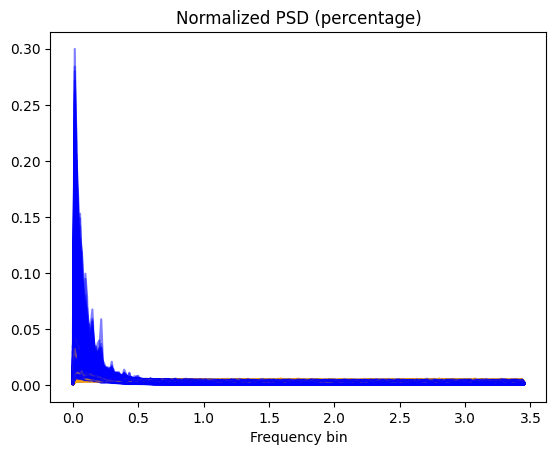

In [435]:
for row, iscell_item in zip(all_psd, metrics_tableManual.iscell):
    if iscell_item == 1:
        color = "blue"
    else:
        color = "orange"
        
    plt.plot(fre, (row + 1e-9), color=color, alpha=0.5)  # one line per trace

plt.xlabel("Frequency bin")
#plt.ylabel("Power (%)")
plt.title("Normalized PSD (percentage)")
plt.show()


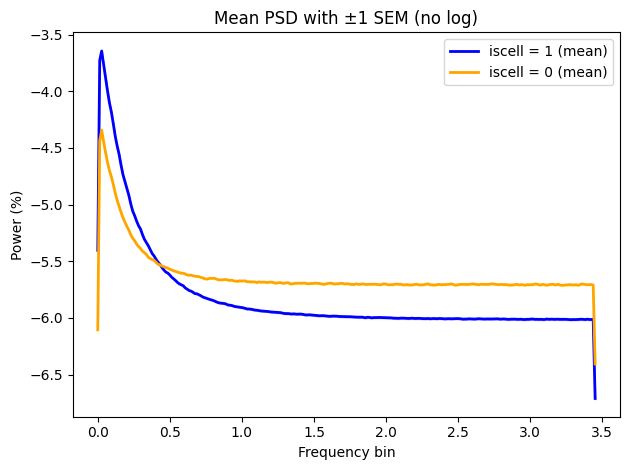

In [434]:
# Arrays from your workspace
psd_array   = np.array(all_psd)
iscell_arr  = np.array(metrics_tableManual.iscell)

# Split groups
psd_cell    = np.log(psd_array[iscell_arr == 1]+0.0000001)
psd_noncell = np.log(psd_array[iscell_arr == 0]+0.0000001)

# Means
mean_cell    = psd_cell.mean(axis=0)
mean_noncell = psd_noncell.mean(axis=0)

# Standard Error of the Mean (SEM)
sem_cell    = psd_cell.std(axis=0, ddof=1) / np.sqrt(psd_cell.shape[0])
sem_noncell = psd_noncell.std(axis=0, ddof=1) / np.sqrt(psd_noncell.shape[0])

# Plot (no log)
plt.figure()
# iscell = 1 (blue)
plt.plot(fre, mean_cell, color="blue", linewidth=2, label="iscell = 1 (mean)")
plt.fill_between(fre, mean_cell - sem_cell, mean_cell + sem_cell,
                 color="blue", alpha=0.2)

# iscell = 0 (yellow)
plt.plot(fre, mean_noncell, color="orange", linewidth=2, label="iscell = 0 (mean)")
plt.fill_between(fre, mean_noncell - sem_noncell, mean_noncell + sem_noncell,
                 color="yellow", alpha=0.25)

plt.xlabel("Frequency bin")
plt.ylabel("Power (%)")
plt.title("Mean PSD with ±1 SEM (no log)")
plt.legend()
plt.tight_layout()
plt.show()


In [456]:
low_band=[0.01, 0.5]
high_band=[2, 3.2]
#QC.low_high_ratio(np.array(all_psd),fre,low_band,high_band)
metrics_tableManual["LHR"]=QC.low_high_ratio(np.array(all_psd),fre,low_band,high_band)

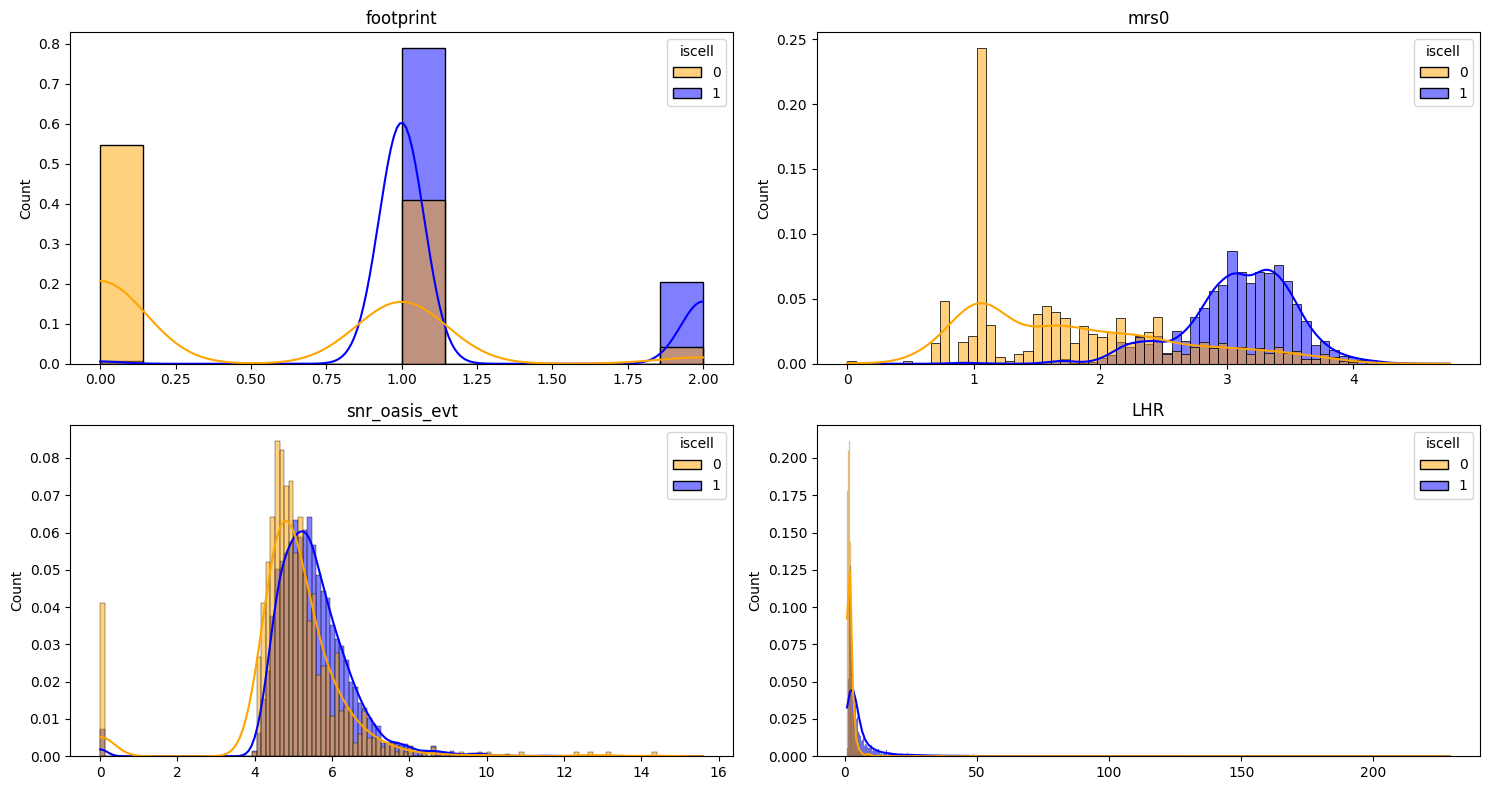

In [463]:
ncols = int(np.ceil(len(metrics_subset) / 2))   # columns needed
fig, axes = plt.subplots(2, ncols, figsize=(15, 8))  
axes = axes.flatten()

for idx, col in enumerate(metrics_subset):
    ax = axes[idx]
    sns.histplot(
        data=metrics_tableManual,
        x=col,
        hue='iscell',
        hue_order=[0, 1],
        stat='probability',
        common_norm=False,
        kde=True,
        palette={0: "orange", 1: "blue"},
        alpha=0.5,
        ax=ax
    )
    ax.set_title(col)
    ax.set_ylabel("Count")
    ax.set_xlabel("")

plt.tight_layout()
plt.show()


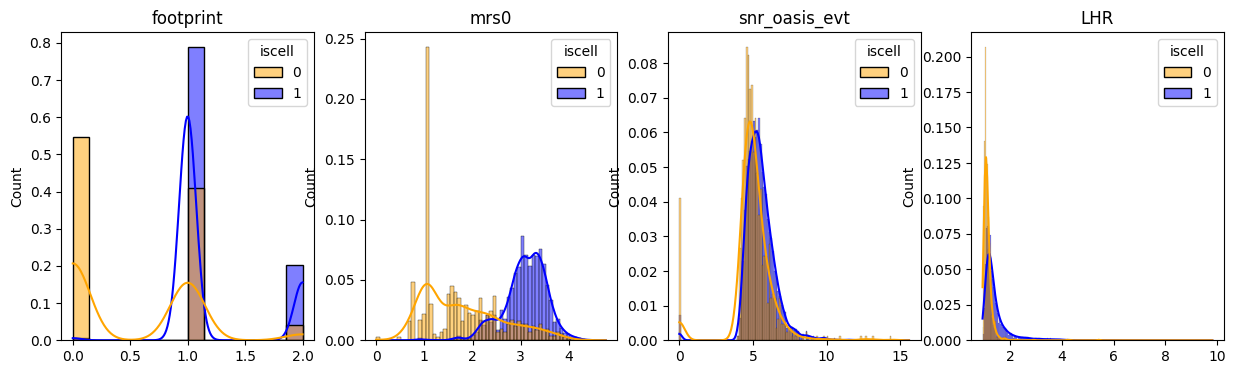

In [449]:
fig, axes = plt.subplots(1, 4, figsize=(15, 4))
axes = axes.flatten()
metrics_subset = ['footprint','mrs0','snr_oasis_evt','LHR']

for idx, col in enumerate(metrics_subset):
    ax = axes[idx]
    sns.histplot(
        data=metrics_tableManual,
        x=metrics_subset[idx],
        hue='iscell',
        hue_order=[0, 1],
        stat="probability",
        common_norm=False,
        kde=True,
        palette={0: "orange", 1: "blue"},
        alpha=0.5,
        ax=ax
    )  # <-- close the histplot here

    ax.set_title(col)
    ax.set_ylabel("Count")
    ax.set_xlabel("")

plt.show()


In [401]:
out = QC.save_pairwise_scatter_pdf(
    data=metrics_tableManual,
    metrics_subset=['footprint', 'mrs0', 'snr_oasis_evt', 'compact', 'npix', 'skew', 'solidity', 'npix_norm', 'radius'],
    pdf_path=r"\\nimhlabstore1.nimh.nih.gov\UFNC\FNC2\Zhang\Projects\Project-LocalProcessing\Step1\metric_pairs.pdf",
    hue_col="iscell",          # optional; defaults to 'iscell'
)
print("Saved to:", out)


Saved to: \\nimhlabstore1.nimh.nih.gov\UFNC\FNC2\Zhang\Projects\Project-LocalProcessing\Step1\metric_pairs.pdf


In [579]:
importlib.reload(QC)
metrics_table_sub = metrics_tableManual.loc[metrics_tableManual['footprint'] > 0.1].copy()
out = save_pairwise_scatter_pdf(
    data=metrics_table_sub,
    metrics_subset=['mrs0', 'snr_oasis_evt', 'compact', 'npix', 'skew', 'solidity', 'npix_norm', 'radius','LHR'],
    pdf_path=r"\\nimhlabstore1.nimh.nih.gov\UFNC\FNC2\Zhang\Projects\Project-LocalProcessing\Step1\metric_pairsExfootprintLow.pdf",
    hue_col="iscell",          # optional; defaults to 'iscell'
)
print("Saved to:", out)


Saved to: \\nimhlabstore1.nimh.nih.gov\UFNC\FNC2\Zhang\Projects\Project-LocalProcessing\Step1\metric_pairsExfootprintLow.pdf


In [502]:



#mask = metrics_tableManual['footprint'] > 0.1

# Subset the metrics table
metrics_table_sub = metrics_tableManual.loc[metrics_tableManual['footprint'] > 0.1].copy()

# Subset the iscell vector *in the same way*
# (assumes metrics_tableManual['iscell'] aligns 1:1 with metrics_table rows)
#iscell_full = np.asarray(metrics_tableManual['iscell']).reshape(-1)
#assert len(iscell_full) == len(metrics_table), "iscell length must match metrics_table rows"
#iscell_sub = metrics_table_sub.iscell

# Save the distributions PDF for the filtered rows
out = QC.save_metric_distributions_pdf(
    metrics_table=metrics_tableManual,
    iscell=metrics_tableManual.iscell,
    pdf_path=r"\\nimhlabstore1.nimh.nih.gov\UFNC\FNC2\Zhang\Projects\Project-LocalProcessing\Step1\metrics_distributionsManual.pdf",
    probability=True,
)

print("Saved to:", out)

Saved to: \\nimhlabstore1.nimh.nih.gov\UFNC\FNC2\Zhang\Projects\Project-LocalProcessing\Step1\metrics_distributionsManual.pdf


In [404]:



#mask = metrics_tableManual['footprint'] > 0.1

# Subset the metrics table
metrics_table_sub = metrics_tableManual.loc[metrics_tableManual['footprint'] > 0.1].copy()

# Subset the iscell vector *in the same way*
# (assumes metrics_tableManual['iscell'] aligns 1:1 with metrics_table rows)
#iscell_full = np.asarray(metrics_tableManual['iscell']).reshape(-1)
#assert len(iscell_full) == len(metrics_table), "iscell length must match metrics_table rows"
#iscell_sub = metrics_table_sub.iscell

# Save the distributions PDF for the filtered rows
out = QC.save_metric_distributions_pdf(
    metrics_table=metrics_table_sub,
    iscell=metrics_table_sub.iscell,
    pdf_path=r"\\nimhlabstore1.nimh.nih.gov\UFNC\FNC2\Zhang\Projects\Project-LocalProcessing\Step1\metrics_distributionsManualFootPrintExc.pdf",
    probability=True,
)

print("Saved to:", out)

Saved to: \\nimhlabstore1.nimh.nih.gov\UFNC\FNC2\Zhang\Projects\Project-LocalProcessing\Step1\metrics_distributionsManualFootPrintExc.pdf


C:\Users\zhangl33\AppData\Local\Temp\ipykernel_12540\679956824.py:104: MatplotlibDeprecationWarning: Keeping empty pdf files is deprecated since 3.8 and support will be removed two minor releases later.
  plt.close(fig)


ValueError: Data must be 1-dimensional, got ndarray of shape (6187, 2) instead

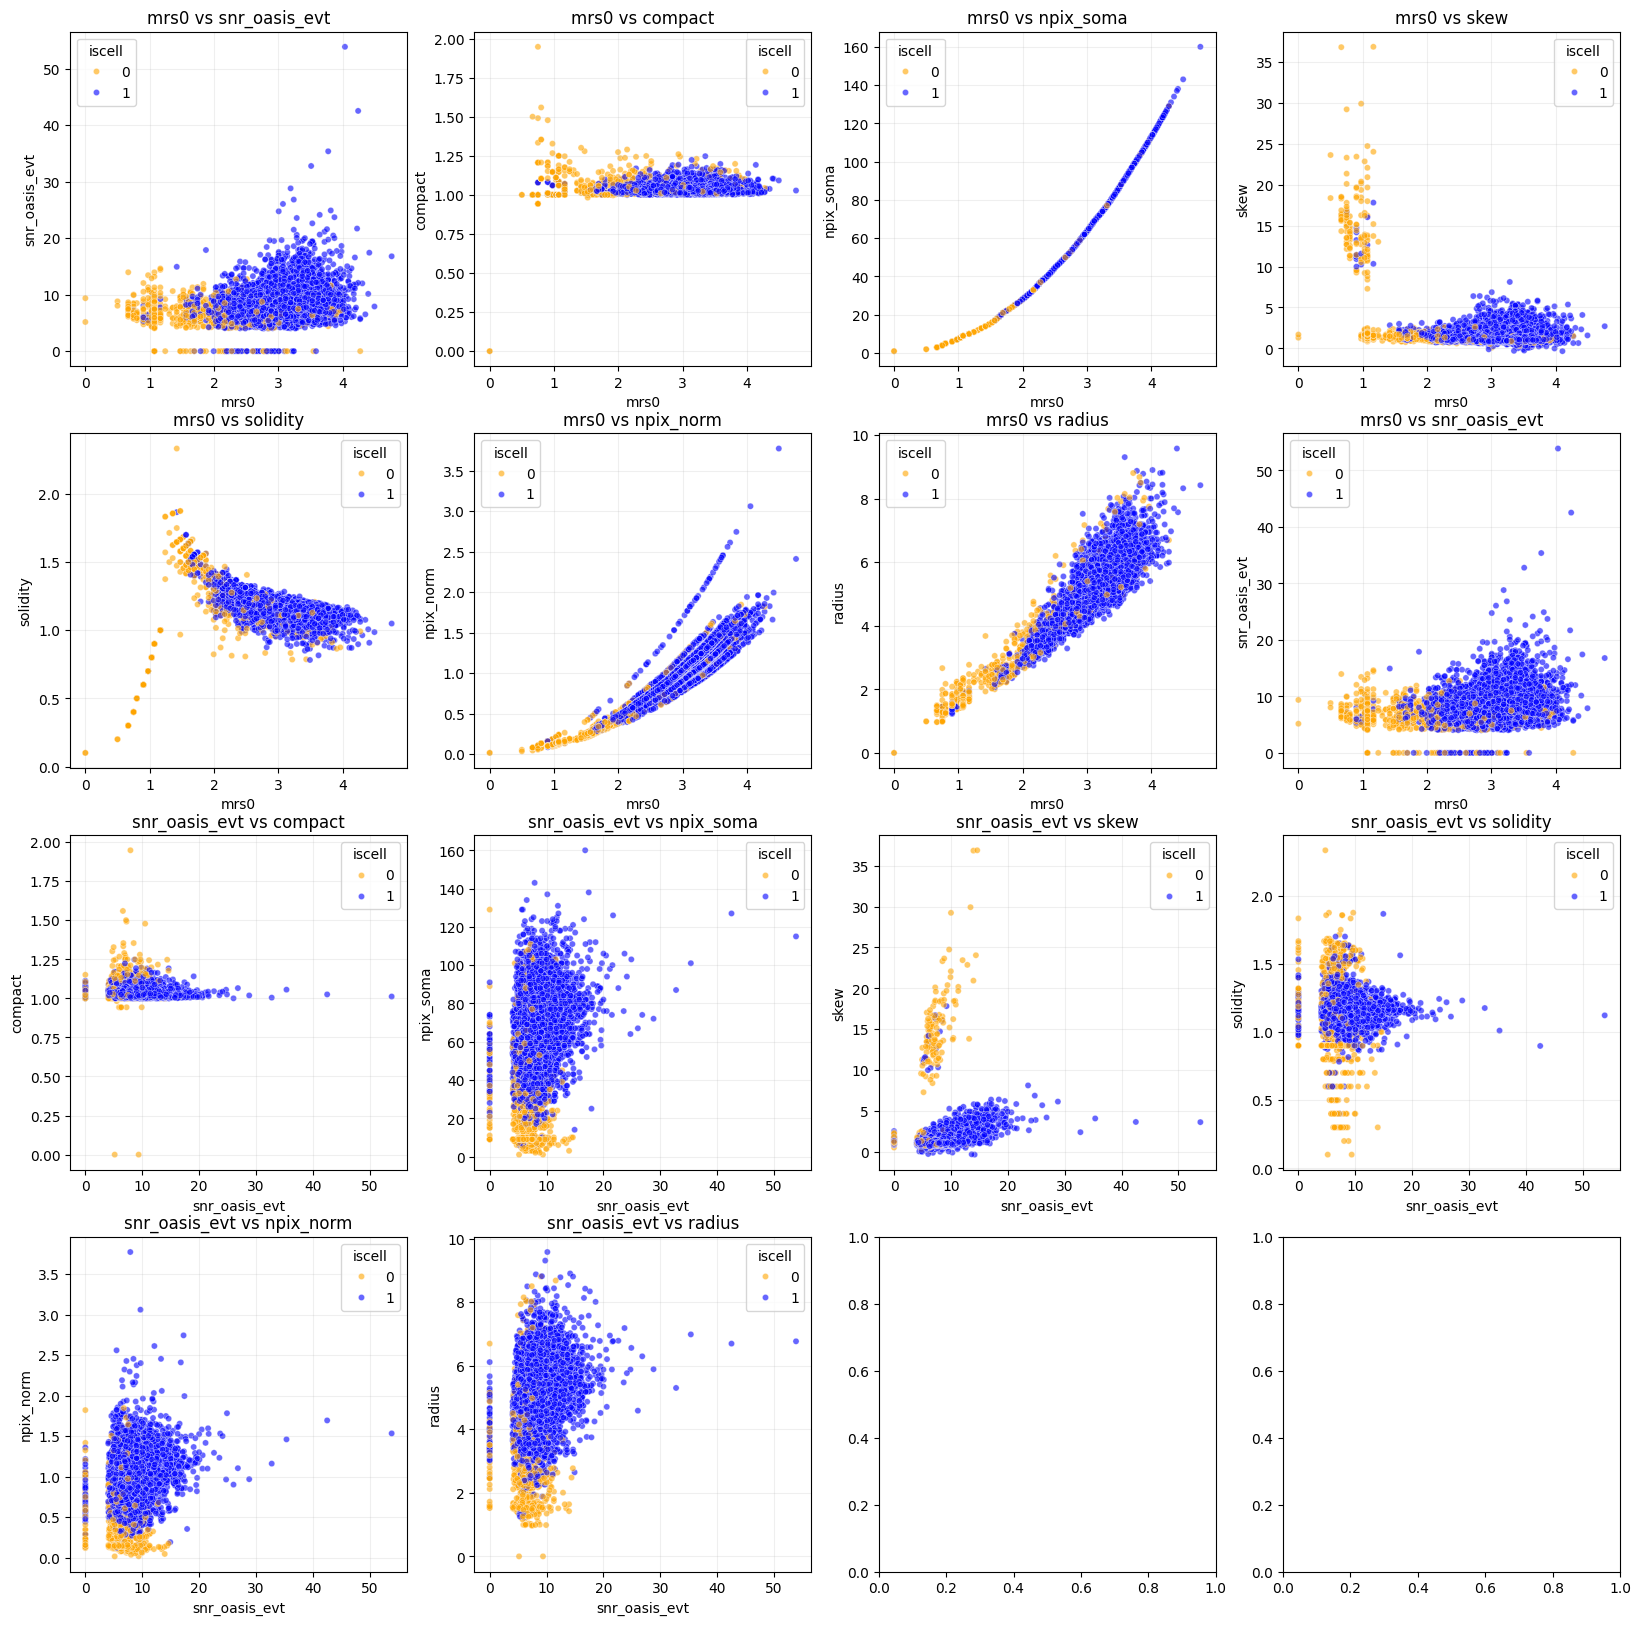

In [399]:

out = save_pairwise_scatter_pdf(
     data=metrics_tableManual,
     metrics_subset=['mrs0', 'snr_oasis_evt', 'compact', ''mrs0','npix_soma', 'skew', 'solidity', 'npix_norm', 'radius','snr_oasis_evt'],
     pdf_path=r"\\nimhlabstore1.nimh.nih.gov\UFNC\FNC2\Zhang\Projects\Project-LocalProcessing\Step1\metric_pairsFootPrintExc.pdf",
 )
print("Saved to:", out)

In [563]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve, f1_score
)

def _make_pipe(model_type="svm"):
    if model_type == "logreg":
        model = LogisticRegression(penalty="l2", solver="lbfgs", max_iter=2000, class_weight="balanced")
    elif model_type == "svm":
        model = SVC(kernel="rbf", C=1.0, gamma="scale", probability=True, class_weight="balanced")
    else:
        raise ValueError("model_type must be 'svm' or 'logreg'")
    return Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", model),
    ])



def vis_logreg_weights(results, feature_names):
    """
    Visualize logistic regression weights directly from results dict.

    Parameters
    ----------
    results : dict
        Results dictionary (e.g., logreg_res) that contains 'feature_weights'.
    feature_names : list
        Names of the features corresponding to the model inputs.
    """
    if "feature_weights" not in results:
        raise ValueError("No feature_weights found in results. Did you run with model_type='logreg'?")

    weights = results["feature_weights"].sort_values()

    plt.figure(figsize=(8, 6))
    weights.plot(kind="barh")
    plt.title("Logistic Regression Weights")
    plt.xlabel("Weight (contribution)")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    return weights

def plot_curves(y_true, y_prob, title="Model"):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = roc_auc_score(y_true, y_prob)
    prec, rec, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
    axes[0].plot([0, 1], [0, 1], linestyle="--", color="gray")
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[0].set_title(f"ROC Curve ({title})")
    axes[0].legend()

    axes[1].plot(rec, prec, label=f"PR AUC = {pr_auc:.3f}")
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")
    axes[1].set_title(f"Precision-Recall Curve ({title})")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

def best_thresholds(y_true, y_prob):
    thresholds = np.linspace(0, 1, 501)
    best_acc, best_f1 = 0, 0
    best_acc_t, best_f1_t = 0.5, 0.5
    for t in thresholds:
        yhat = (y_prob >= t).astype(int)
        acc = accuracy_score(y_true, yhat)
        f1 = f1_score(y_true, yhat)
        if acc > best_acc:
            best_acc, best_acc_t = acc, t
        if f1 > best_f1:
            best_f1, best_f1_t = f1, t
    return {"best_acc": best_acc, "best_acc_t": best_acc_t, "best_f1": best_f1, "best_f1_t": best_f1_t}

def compare_footprint_strategies(
    df: pd.DataFrame,
    metrics_subset: list,
    label="iscell",
    footprint_col="footprint",
    model_type="svm",
    test_size=0.25,
    random_state=42,
    cv_folds=5,
    print_summary=True,
    plot_curves_flag=True,
    plot_weights_flag=True
):
    """Compare three strategies, simulate hard rule in CV, visualize logreg weights, and auto-report best thresholds."""

    y = df[label].astype(int).to_numpy()
    Xtr_idx, Xte_idx, ytr, yte = train_test_split(
        np.arange(len(df)), y, test_size=test_size, stratify=y, random_state=random_state
    )
    df_tr = df.iloc[Xtr_idx].copy()
    df_te = df.iloc[Xte_idx].copy()

    results, probs_out = {}, {}

    # Helper to add threshold analysis
    def add_threshold_info(name, ytrue, yprob):
        thres = best_thresholds(ytrue, yprob)
        results[name]["best_acc"] = thres["best_acc"]
        results[name]["best_acc_t"] = thres["best_acc_t"]
        results[name]["best_f1"] = thres["best_f1"]
        results[name]["best_f1_t"] = thres["best_f1_t"]

    # --- Strategy 1: Direct with footprint
    feats1 = metrics_subset.copy()
    pipe1 = _make_pipe(model_type)
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
    cv_auc1 = []
    for tr_idx, va_idx in cv.split(df_tr, df_tr[label].astype(int)):
        pipe1.fit(df_tr.iloc[tr_idx][feats1], df_tr.iloc[tr_idx][label].astype(int))
        yprob_val = pipe1.predict_proba(df_tr.iloc[va_idx][feats1])[:, 1]
        cv_auc1.append(roc_auc_score(df_tr.iloc[va_idx][label].astype(int), yprob_val))
    pipe1.fit(df_tr[feats1], df_tr[label].astype(int))
    yprob1 = pipe1.predict_proba(df_te[feats1])[:, 1]
    yhat1 = (yprob1 >= 0.5).astype(int)
    results["direct_with_footprint"] = {
        "cv_auc_mean": float(np.mean(cv_auc1)),
        "cv_auc_std": float(np.std(cv_auc1)),
        "test_accuracy": float(accuracy_score(yte, yhat1)),
        "test_roc_auc": float(roc_auc_score(yte, yprob1)),
        "test_pr_auc": float(average_precision_score(yte, yprob1)),
    }
    probs_out["direct_with_footprint"] = yprob1
    add_threshold_info("direct_with_footprint", yte, yprob1)
    if plot_curves_flag:
        plot_curves(yte, yprob1, title="Direct with footprint")

    # Masks for strategies 2 & 3
    rule_mask_te = (df_te[footprint_col] == 0)
    rest_mask_te = ~rule_mask_te
    train_mask_rule = (df_tr[footprint_col] != 0)

    # --- Strategy 2: Rule + model WITHOUT footprint
    feats2 = [f for f in metrics_subset if f != footprint_col]
    pipe2 = _make_pipe(model_type)
    cv_auc2 = []
    for tr_idx, va_idx in cv.split(df_tr, df_tr[label].astype(int)):
        Xtr_fold, Xva_fold = df_tr.iloc[tr_idx], df_tr.iloc[va_idx]
        yprob_val = np.empty(len(Xva_fold))
        rule_mask_val = (Xva_fold[footprint_col] == 0)
        rest_mask_val = ~rule_mask_val
        pipe2.fit(Xtr_fold.loc[Xtr_fold[footprint_col] != 0, feats2], Xtr_fold.loc[Xtr_fold[footprint_col] != 0, label].astype(int))
        yprob_val[rule_mask_val.values] = 0.0
        yprob_val[rest_mask_val.values] = pipe2.predict_proba(Xva_fold.loc[rest_mask_val, feats2])[:, 1]
        cv_auc2.append(roc_auc_score(Xva_fold[label].astype(int), yprob_val))
    pipe2.fit(df_tr.loc[train_mask_rule, feats2], df_tr.loc[train_mask_rule, label].astype(int))
    yprob_rest2 = pipe2.predict_proba(df_te.loc[rest_mask_te, feats2])[:, 1]
    yprob2 = np.empty_like(yte, dtype=float)
    yprob2[rule_mask_te.values] = 0.0
    yprob2[rest_mask_te.values] = yprob_rest2
    yhat2 = (yprob2 >= 0.5).astype(int)
    results["rule_then_model_without_footprint"] = {
        "cv_auc_mean": float(np.mean(cv_auc2)),
        "cv_auc_std": float(np.std(cv_auc2)),
        "test_accuracy": float(accuracy_score(yte, yhat2)),
        "test_roc_auc": float(roc_auc_score(yte, yprob2)),
        "test_pr_auc": float(average_precision_score(yte, yprob2)),
    }
    probs_out["rule_then_model_without_footprint"] = yprob2
    add_threshold_info("rule_then_model_without_footprint", yte, yprob2)
    if plot_curves_flag:
        plot_curves(yte, yprob2, title="Rule + model without footprint")

    # --- Strategy 3: Rule + model WITH footprint
    feats3 = metrics_subset.copy()
    pipe3 = _make_pipe(model_type)
    cv_auc3 = []
    for tr_idx, va_idx in cv.split(df_tr, df_tr[label].astype(int)):
        Xtr_fold, Xva_fold = df_tr.iloc[tr_idx], df_tr.iloc[va_idx]
        yprob_val = np.empty(len(Xva_fold))
        rule_mask_val = (Xva_fold[footprint_col] == 0)
        rest_mask_val = ~rule_mask_val
        pipe3.fit(Xtr_fold.loc[Xtr_fold[footprint_col] != 0, feats3], Xtr_fold.loc[Xtr_fold[footprint_col] != 0, label].astype(int))
        yprob_val[rule_mask_val.values] = 0.0
        yprob_val[rest_mask_val.values] = pipe3.predict_proba(Xva_fold.loc[rest_mask_val, feats3])[:, 1]
        cv_auc3.append(roc_auc_score(Xva_fold[label].astype(int), yprob_val))
    pipe3.fit(df_tr.loc[train_mask_rule, feats3], df_tr.loc[train_mask_rule, label].astype(int))
    yprob_rest3 = pipe3.predict_proba(df_te.loc[rest_mask_te, feats3])[:, 1]
    yprob3 = np.empty_like(yte, dtype=float)
    yprob3[rule_mask_te.values] = 0.0
    yprob3[rest_mask_te.values] = yprob_rest3
    yhat3 = (yprob3 >= 0.5).astype(int)
    results["rule_then_model_with_footprint"] = {
        "cv_auc_mean": float(np.mean(cv_auc3)),
        "cv_auc_std": float(np.std(cv_auc3)),
        "test_accuracy": float(accuracy_score(yte, yhat3)),
        "test_roc_auc": float(roc_auc_score(yte, yprob3)),
        "test_pr_auc": float(average_precision_score(yte, yprob3)),
    }
    probs_out["rule_then_model_with_footprint"] = yprob3
    add_threshold_info("rule_then_model_with_footprint", yte, yprob3)
    if plot_curves_flag:
        plot_curves(yte, yprob3, title="Rule + model with footprint")

    if print_summary:
        for name, r in results.items():
            print(f"\n=== {name} ===")
            print(f"CV AUC: {r['cv_auc_mean']:.3f} ± {r['cv_auc_std']:.3f}")
            print(f"Test Accuracy (0.5 threshold): {r['test_accuracy']:.3f}")
            print(f"Test ROC AUC: {r['test_roc_auc']:.3f}")
            print(f"Test PR  AUC: {r['test_pr_auc']:.3f}")
            print(f"Best Accuracy: {r['best_acc']:.3f} at threshold {r['best_acc_t']:.3f}")
            print(f"Best F1: {r['best_f1']:.3f} at threshold {r['best_f1_t']:.3f}")

    return results, yte, probs_out

In [575]:
# Build list of numeric metric columns, excluding any extras
exclude = {"iscell"}

all_metrics = (
    metrics_tableManual
    .select_dtypes(include=[float, int])
    .columns
    .difference(exclude, sort=False)
)
print(metric_columns)

Index(['footprint', 'compact', 'aspect_ratio', 'npix', 'skew', 'mrs', 'mrs0',
       'solidity', 'npix_soma', 'npix_norm', 'npix_norm_no_crop', 'radius',
       'std', 'A_evt', 'sigma_psd', 'snr_oasis_evt', 'LHR'],
      dtype='object')


LogReg CV AUC: 0.9456026320012839 ± 0.006566660747715015
Test ROC AUC: 0.9361165188550002
              precision    recall  f1-score   support

non-cell (0)       0.58      0.80      0.67       207
    cell (1)       0.97      0.91      0.94      1340

    accuracy                           0.90      1547
   macro avg       0.77      0.85      0.81      1547
weighted avg       0.92      0.90      0.90      1547

mrs0                 6.514716
LHR                  4.157802
npix_norm_no_crop    1.000175
mrs                  0.917279
sigma_psd            0.841860
snr_oasis_evt        0.544752
skew                 0.376499
aspect_ratio         0.308904
solidity             0.128913
footprint            0.000884
radius              -0.051451
A_evt               -0.127358
compact             -0.870604
npix                -1.415709
std                 -1.875693
npix_norm           -2.074662
npix_soma           -3.038942
dtype: float64


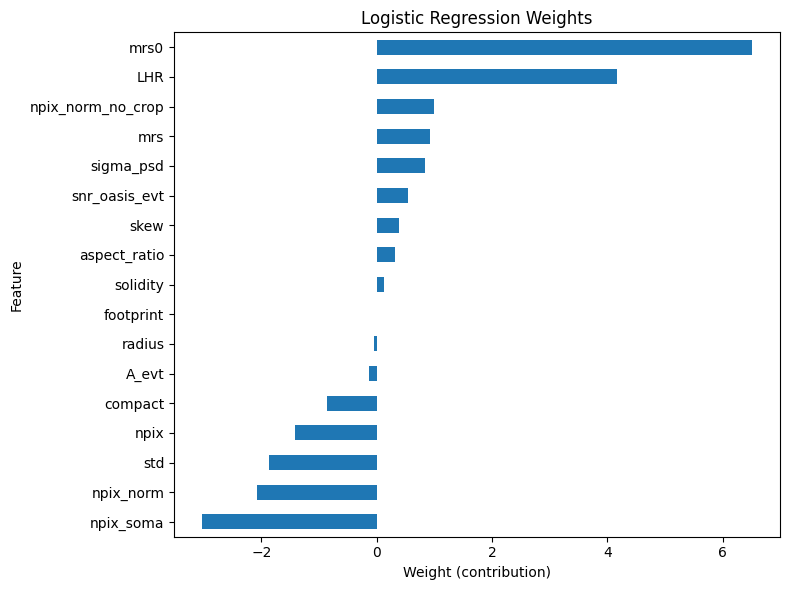

SVM CV AUC: 0.951400256780613 ± 0.0049221270090449324
Test ROC AUC: 0.9395107794361525
              precision    recall  f1-score   support

non-cell (0)       0.59      0.82      0.69       207
    cell (1)       0.97      0.91      0.94      1340

    accuracy                           0.90      1547
   macro avg       0.78      0.87      0.81      1547
weighted avg       0.92      0.90      0.91      1547



In [576]:
#metrics_subset = ['footprint','snr_oasis_evt','solidity','compact','npix_norm']  # pick what you want
#metrics_subset = ['mrs0', 'snr_oasis_evt','skew','solidity','compact','sigma_psd']  # pick what you want
metrics_subset = ['footprint','snr_oasis_evt','solidity','compact','sigma_psd','npix_norm','radius']  # pick what you want
metrics_subset = ['footprint','compact','','snr_oasis_evt','solidity','compact','sigma_psd','npix_norm','radius']  # pick what you want
metrics_subset = all_metrics
# Logistic regression
logreg_model, logreg_res = train_decoder(metrics_tableManual, metrics_subset, label='iscell', model_type='logreg')
print("LogReg CV AUC:", logreg_res["cv_auc_mean"], "±", logreg_res["cv_auc_std"])
print("Test ROC AUC:", logreg_res["test_roc_auc"])
print(logreg_res["report"])
if "feature_weights" in logreg_res:
    print(logreg_res["feature_weights"])

# If you trained with model_type="logreg" and kept the fitted pipeline in `logreg_model`:
weights = vis_logreg_weights(logreg_res, feature_names=metrics_subset)
#print(weights)

#print(weights)  # to see numeric coefficients

# SVM
svm_model, svm_res = train_decoder(metrics_tableManual, metrics_subset, label='iscell', model_type='svm')
print("SVM CV AUC:", svm_res["cv_auc_mean"], "±", svm_res["cv_auc_std"])
print("Test ROC AUC:", svm_res["test_roc_auc"])
print(svm_res["report"])





LogReg CV AUC: 0.8583557107053347 ± 0.016498898139665284
Test ROC AUC: 0.8289793633018716
              precision    recall  f1-score   support

non-cell (0)       0.20      0.69      0.31        94
    cell (1)       0.97      0.81      0.88      1330

    accuracy                           0.80      1424
   macro avg       0.59      0.75      0.60      1424
weighted avg       0.92      0.80      0.85      1424

radius           1.296948
snr_oasis_evt    0.617742
npix_norm        0.119118
solidity         0.015191
sigma_psd       -0.057988
footprint       -0.555883
compact         -1.047357
dtype: float64


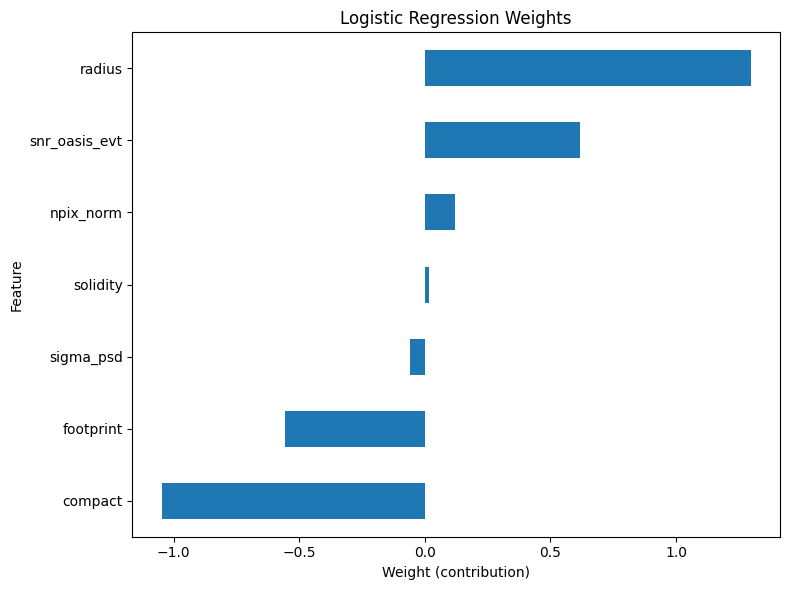

SVM CV AUC: 0.8776002506265664 ± 0.01274967064214043
Test ROC AUC: 0.8416573348264277
              precision    recall  f1-score   support

non-cell (0)       0.22      0.69      0.34        94
    cell (1)       0.97      0.83      0.90      1330

    accuracy                           0.82      1424
   macro avg       0.60      0.76      0.62      1424
weighted avg       0.92      0.82      0.86      1424



In [587]:
metrics_table_sub = metrics_tableManual.loc[metrics_tableManual['footprint'] > 0.1].copy()
metrics_subset = ['footprint','snr_oasis_evt','solidity','compact','sigma_psd','npix_norm','radius']  # pick what you want
metrics_subset = ['footprint','snr_oasis_evt','solidity','compact','sigma_psd','npix_norm','radius']  # pick what you want
#metrics_subset = all_metrics
# Logistic regression
logreg_model, logreg_res = train_decoder(metrics_table_sub, metrics_subset, label='iscell', model_type='logreg')
print("LogReg CV AUC:", logreg_res["cv_auc_mean"], "±", logreg_res["cv_auc_std"])
print("Test ROC AUC:", logreg_res["test_roc_auc"])
print(logreg_res["report"])
if "feature_weights" in logreg_res:
    print(logreg_res["feature_weights"])

# If you trained with model_type="logreg" and kept the fitted pipeline in `logreg_model`:
weights = vis_logreg_weights(logreg_res, feature_names=metrics_subset)
#print(weights)

#print(weights)  # to see numeric coefficients

# SVM
svm_model, svm_res = train_decoder(metrics_table_sub, metrics_subset, label='iscell', model_type='svm')
print("SVM CV AUC:", svm_res["cv_auc_mean"], "±", svm_res["cv_auc_std"])
print("Test ROC AUC:", svm_res["test_roc_auc"])
print(svm_res["report"])





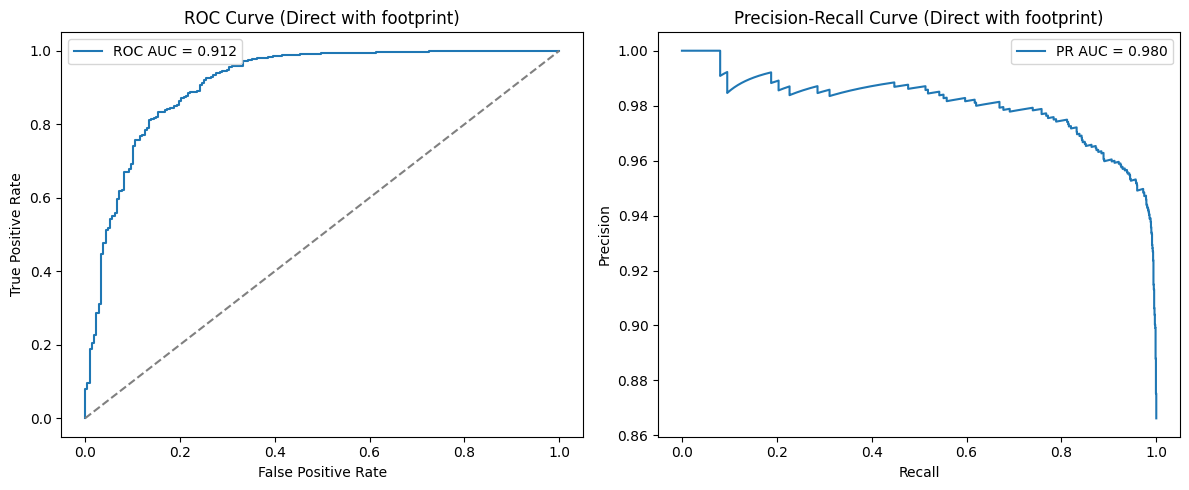

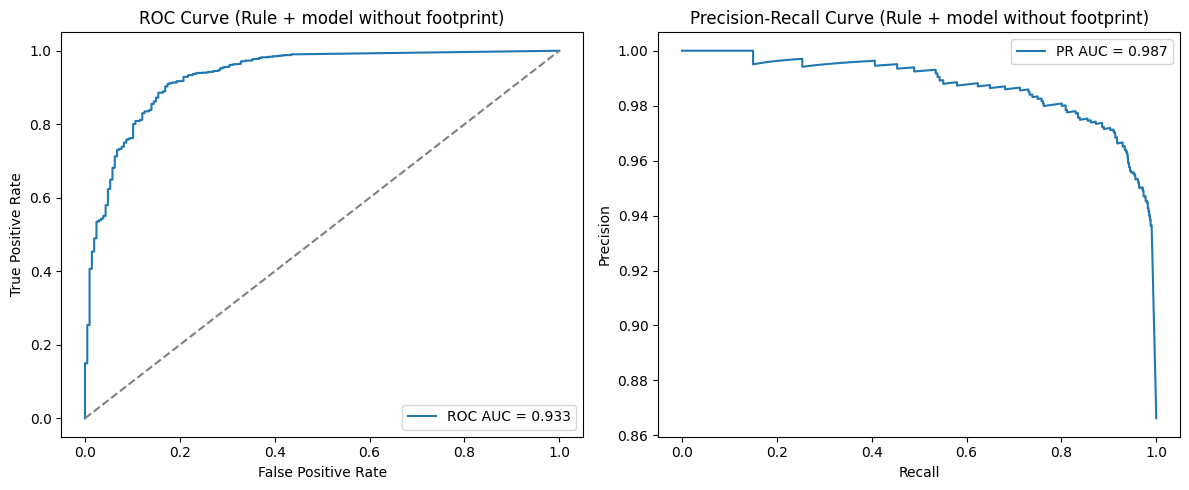

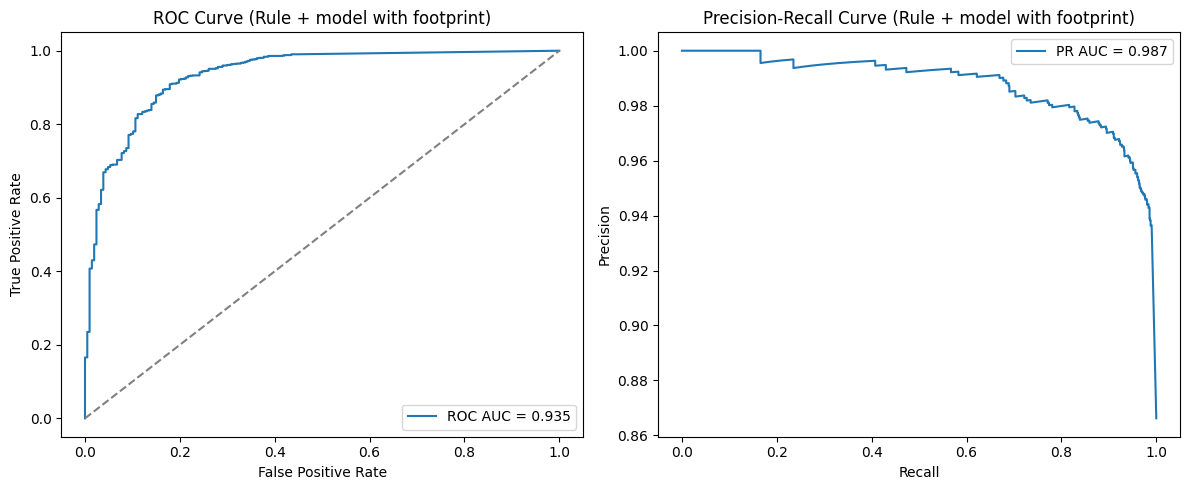


=== direct_with_footprint ===
CV AUC: 0.918 ± 0.014
Test Accuracy (0.5 threshold): 0.870
Test ROC AUC: 0.912
Test PR  AUC: 0.980
Best Accuracy: 0.934 at threshold 0.130
Best F1: 0.963 at threshold 0.130

=== rule_then_model_without_footprint ===
CV AUC: 0.938 ± 0.010
Test Accuracy (0.5 threshold): 0.803
Test ROC AUC: 0.933
Test PR  AUC: 0.987
Best Accuracy: 0.935 at threshold 0.080
Best F1: 0.963 at threshold 0.080

=== rule_then_model_with_footprint ===
CV AUC: 0.939 ± 0.012
Test Accuracy (0.5 threshold): 0.809
Test ROC AUC: 0.935
Test PR  AUC: 0.987
Best Accuracy: 0.935 at threshold 0.062
Best F1: 0.964 at threshold 0.062


In [544]:
metrics_subset = ['footprint','mrs0', 'snr_oasis_evt','skew','solidity','compact','sigma_psd']  # pick what you wa
results, yte, probs_out = compare_footprint_strategies(
    df=metrics_tableManual,
    metrics_subset=metrics_subset,
    label='iscell',
    footprint_col='footprint',
    model_type='logreg',
    plot_curves_flag=True
)


In [527]:
# Strategy 1 vs Strategy 2: why Test ROC/PR can look better while Test Accuracy is worse
# -------------------------------------------------------------------------------
# Key idea: ROC AUC and PR AUC evaluate how well the *scores rank* positives above
# negatives across *all thresholds*. Test Accuracy evaluates performance at a
# *single threshold* (usually 0.5). A model (or pipeline) can rank very well
# (high ROC/PR) yet be poorly calibrated or use a sub‑optimal threshold, leading
# to lower accuracy.
# 
# What’s happening in Strategy 2 (Rule + model):
# 1) You hard‑assign all rows with footprint==0 to class 0 and set their
#    probability for class 1 to 0.0. This can improve ranking (ROC AUC) if most
#    of those rows truly are class 0, because they get pushed to the very bottom
#    of the score list.
# 2) But accuracy is computed at a fixed cutoff (0.5). If some footprint==0 rows
#    are actually class 1 (cells), they are *guaranteed* to be misclassified at
#    that cutoff, reducing accuracy—even while the overall ranking can still look
#    good.
# 3) Also, Strategy 2 combines a deterministic rule with an ML model. The
#    resulting scores are not necessarily well‑calibrated around 0.5.
# 
# Why Strategy 1 shows higher Accuracy (0.903 vs 0.860) despite slightly lower ROC:
# - Strategy 1’s probabilities are produced by a single trained model and tend to
#   be better calibrated around the default 0.5 threshold. That yields a better
#   0/1 split at that cutoff.
# - Strategy 2’s hard rule improves the ranking (ROC/PR) but injects systematic
#   errors at the default threshold, hurting accuracy.
# 
# Practical fixes if you want Strategy 2 to have higher Accuracy:
# - Tune the decision threshold (don’t force 0.5). Pick the threshold that
#   maximizes accuracy or F1 on a validation set.
# - Calibrate probabilities (e.g., CalibratedClassifierCV) for the ML part, and
#   consider a softer rule (e.g., set ruled rows to a small non‑zero probability
#   instead of hard 0.0).
# 
# Threshold sweep example for Strategy 2 (given yte and the final combined yprob2):
# -------------------------------------------------------------------------------
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def pick_best_threshold(y_true, y_prob, metric="accuracy"):
    """Find threshold in [0,1] that maximizes accuracy or F1."""
    thresholds = np.linspace(0, 1, 501)
    scores = []
    for t in thresholds:
        yhat = (y_prob >= t).astype(int)
        if metric == "accuracy":
            scores.append(accuracy_score(y_true, yhat))
        elif metric == "f1":
            scores.append(f1_score(y_true, yhat))
        else:
            raise ValueError("metric must be 'accuracy' or 'f1'")
    best_idx = int(np.argmax(scores))
    return thresholds[best_idx], scores[best_idx]

# Usage (after running compare_footprint_strategies and capturing outputs):
# t_acc, best_acc = pick_best_threshold(yte, yprob2, metric="accuracy")
# t_f1,  best_f1  = pick_best_threshold(yte, yprob2, metric="f1")
# print(f"Best threshold for accuracy: {t_acc:.3f}, accuracy={best_acc:.3f}")
# print(f"Best threshold for F1      : {t_f1:.3f}, F1={best_f1:.3f}")


In [529]:
# The error means that variables yte and yprob2 are not available in your notebook scope.
# They were created *inside* the compare_footprint_strategies function but not returned.

# To use the threshold sweep, you need to either:
# 1. Modify compare_footprint_strategies to also return yte and yprob2
#    (for Strategy 2, rule + model without footprint).
# or
# 2. Recompute yte and yprob2 outside the function using the same train/test split.

# --- Option 1: Modify the function return ---
# Example:
# return results, yte, yprob2

# Then call:
# res, yte, yprob2 = compare_footprint_strategies(...)

# Now you can run:
t_acc, best_acc = pick_best_threshold(yte, yprob2, metric="accuracy")
t_f1, best_f1   = pick_best_threshold(yte, yprob2, metric="f1")
print("Best Accuracy:", best_acc, "at threshold", t_acc)
print("Best F1:", best_f1, "at threshold", t_f1)

NameError: name 'yte' is not defined

In [34]:
## all awake with initial refImg defined in spontanous data
RefKeyword = ['Spon']
FunColorValue = [0.0,0.0,0.0]
sucTable = []
DistTh=10
ops0['threshold_scaling']=0.9

all_metrics = []
for i in range(0,FOV.shape[1]):
#for i in range(3,4):
    FOVtemp = FOV[0, i]
    FOVtempSave=FOVsave_updated[0,i]
    print(FOVtempSave)
    FOVtempRef = FOVref[0,i]
    dfTemp=dfs[i]
    #print(FOVtemp['DataFolder'])   # or whatever field you want
    ops0['data_path']=FOVtemp['DataFolder']
    #ops0['save_path0']=r'E:/LuSLMOnlineTest/SL0855-Emx1G6CII-AAV9CAMKII/03042025/SingleP/Top44SpeedStimEdgeExc/Data/'
    file_ids = dfTemp.loc[dfTemp['AwakeState'] < 2,'FileID']   
    TiffNum = dfTemp.loc[dfTemp['AwakeState'] < 2, 'Suite2pTiffNum']
    #print(TiffNum.sum(),' tiff files')
    subFileRange = (file_ids.min(), file_ids.max())
    root     = Path(ops0['data_path'][0])
    folder_name = f"sub{subFileRange[0]}-{subFileRange[1]}awakeRef{RefKeyword[0]}"
    #full_save_path = os.path.join(FOVtempSave[0], folder_name)
    full_save_path = os.path.join(FOVtempSave, folder_name)
    suite2pdir= os.path.join(full_save_path, 'suite2p')
    
    confdir=root.parent.parent.parent
    FilteredPos3D, FilteredFunScore, FilteredTestPos3D, FilteredTestTBL = slmO.load_slm_data(root.parent)
    confSet=FBS.read_yaml(os.path.join(confdir,'CurrentSLMsetting.yml'))

    
    
    
    names, pairs = slmO.subfolders_and_pairs(FOVtempRef[0],RefKeyword)
    #reffull_save_path = os.path.join(FOVtempRef[0], names[0])
    #refsuite2pdir= os.path.join(reffull_save_path, 'suite2p')
    #print(refsuite2pdir)
    #print(confSet)
    #CellPos3D, CellPos3DRaw, CaData, CaDataPlane, stat=slmO.extract_suite2p(refsuite2pdir, confSet)
    CellPos3D, CellPos3DRaw, CaData, CaDataPlane, stat=slmO.extract_suite2p(suite2pdir, confSet)
    

    # Create the folder if it doesn't exist
    #os.makedirs(full_save_path, exist_ok=True)
    #ops0['save_path0']= full_save_path
    iscell=np.array(CaData['iscell'][:,0])
    statRaw=CaData['stat']

    df_metrics = extract_metrics_from_stat(statRaw, iscell, FOVtempSave)


    # If your sampling rate is ~6.9 Hz, this band is good:
    fband_69 = (2, 3.3)
    
    # snr, sigma_psd, A_evt, snr_meta = compute_snr_with_suite2p_preprocess(
    #     CaData,
    #     nperseg=512,                 # adjust per trace length; 256 if traces are short
    #     fband=fband_69,              # or None to auto-pick near Nyquist
    #     spks_method='sum',
    #     eps=1e-1,
    #     recompute_spks=False         # you already have CaData['spks']; set True to re-run oasis
    # )
    snr, sigma_psd, A_evt = compute_snr_with_suite2p_preprocess(
        CaData,
        nperseg=512,
        fband=(2, 3.2),   # near Nyquist for fs=6.9
        amp_method="sum",
        min_event_snr=3,          # events must exceed this many sigmas to count
        amp_percentile=0.95,         # robust high-quantile across events
        eps=2,
        recompute_spks=True
    )
    # then add snr, sigma_psd, A_evt as new columns to df_metrics

    
    # Attach to the metrics table (ROI order must match your stat/iscell build)
    df_metrics['A_evt']        = A_evt
    df_metrics['sigma_psd']    = sigma_psd
    df_metrics['snr_oasis_evt']= snr
    #df_metrics['fs_used']      = snr_meta['fs']
   # df_metrics['band_lo']      = snr_meta['band'][0]
    #df_metrics['band_hi']      = snr_meta['band'][1]


    
    all_metrics.append(df_metrics)

# Combine into one big table
metrics_table = pd.concat(all_metrics, ignore_index=True)


\\nimhlabstore1.nimh.nih.gov\UFNC\FNC3Z\Sutie2p-Processed\GCamP6S-CamKIIQualityControl\GCamP6S-CamKII\\SL085503042025\
3
[WindowsPath('//nimhlabstore1.nimh.nih.gov/UFNC/FNC3Z/Sutie2p-Processed/GCamP6S-CamKIIQualityControl/GCamP6S-CamKII/SL085503042025/sub1-60awakeRefSpon/suite2p/plane0'), WindowsPath('//nimhlabstore1.nimh.nih.gov/UFNC/FNC3Z/Sutie2p-Processed/GCamP6S-CamKIIQualityControl/GCamP6S-CamKII/SL085503042025/sub1-60awakeRefSpon/suite2p/plane1'), WindowsPath('//nimhlabstore1.nimh.nih.gov/UFNC/FNC3Z/Sutie2p-Processed/GCamP6S-CamKIIQualityControl/GCamP6S-CamKII/SL085503042025/sub1-60awakeRefSpon/suite2p/plane2')]
3
6.9
0.7
60.0
20.0
\\nimhlabstore1.nimh.nih.gov\UFNC\FNC3Z\Sutie2p-Processed\GCamP6S-CamKIIQualityControl\GCamP6S-CamKII\\SL085503062025\
3
[WindowsPath('//nimhlabstore1.nimh.nih.gov/UFNC/FNC3Z/Sutie2p-Processed/GCamP6S-CamKIIQualityControl/GCamP6S-CamKII/SL085503062025/sub1-101awakeRefSpon/suite2p/plane0'), WindowsPath('//nimhlabstore1.nimh.nih.gov/UFNC/FNC3Z/Sutie2p-Pr

369
369


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 6., 0., 0., 0., 0., 0., 0.,
        0., 0., 1.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <BarContainer object of 20 artists>)

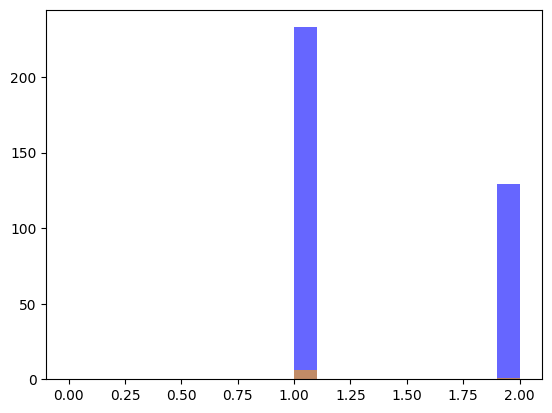

In [40]:
iscell=np.array(CaData['iscell'][:,0])
statRaw=CaData['stat']
print(len(iscell))
print(len(statRaw))
compact = np.array([s['footprint'] for s in statRaw])
# Define bin edges from 0 to 2 with step 0.1
bins = np.arange(0, 2.1, 0.1)  # includes 2.0
#plt.hist(compact[iscell==1])
#plt.hist(compact[iscell==0])
plt.hist(compact[iscell == 1], bins=bins, alpha=0.6, color='blue', label='iscell == 1')
plt.hist(compact[iscell == 0], bins=bins, alpha=0.6, color='orange', label='iscell == 0')


In [85]:
metrics_table

,recording,iscell,footprint,compact,aspect_ratio,npix,skew,mrs,mrs0,solidity,npix_soma,npix_norm,npix_norm_no_crop,radius,std,A_evt,sigma_psd,snr_oasis_evt
0,[\\nimhlabstore1.nimh.nih.gov\UFNC\FNC3Z\Sutie...,1,2.0,1.009148,1.118777,115,1.327161,1.097222,3.643109,1.175000,94,1.381337,1.444905,5.497915,436.380402,0.0,83.301964,0.0
1,[\\nimhlabstore1.nimh.nih.gov\UFNC\FNC3Z\Sutie...,1,2.0,1.009456,1.071979,107,1.390331,1.137172,3.774605,1.134831,101,1.484203,1.344390,5.599684,299.963379,0.0,74.686484,0.0
2,[\\nimhlabstore1.nimh.nih.gov\UFNC\FNC3Z\Sutie...,1,2.0,1.032852,1.227470,134,1.082133,1.204613,3.907887,1.136842,108,1.587068,1.683629,7.025045,513.221924,0.0,93.577749,0.0
3,[\\nimhlabstore1.nimh.nih.gov\UFNC\FNC3Z\Sutie...,1,2.0,1.038065,1.212805,104,2.739457,1.134343,3.661446,1.104651,95,1.396032,1.306697,6.773831,239.025101,0.0,74.975831,0.0
4,[\\nimhlabstore1.nimh.nih.gov\UFNC\FNC3Z\Sutie...,1,2.0,1.014913,1.104745,139,2.074390,1.258440,4.154667,1.145540,122,1.792799,1.746451,6.423872,167.236526,0.0,54.100894,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472,[\\nimhlabstore1.nimh.nih.gov\UFNC\FNC3Z\Sutie...,1,1.0,1.040543,1.150044,41,0.898330,0.670238,2.102699,1.291667,31,0.475387,0.540184,3.344292,115.795212,0.0,111.646305,0.0
473,[\\nimhlabstore1.nimh.nih.gov\UFNC\FNC3Z\Sutie...,1,1.0,1.054016,1.052110,56,1.115860,0.850039,2.632689,1.076923,49,0.751419,0.737813,3.955548,57.335808,0.0,51.674818,0.0
474,[\\nimhlabstore1.nimh.nih.gov\UFNC\FNC3Z\Sutie...,1,2.0,1.041159,1.165734,102,0.961795,1.155959,3.624377,0.989362,93,1.426162,1.343874,6.408635,43.421406,0.0,40.136903,0.0
475,[\\nimhlabstore1.nimh.nih.gov\UFNC\FNC3Z\Sutie...,0,0.0,1.000000,0.971582,16,1.345756,0.328689,1.072984,0.900000,9,0.138016,0.210804,1.525902,134.276443,0.0,128.624207,0.0


In [438]:
importlib.reload(QC)

<module 'Suite2p_QualityControl' from 'C:\\Users\\zhangl33\\Projects\\Project-SLMonlineControl\\CodeAndPackages\\PYsubfun\\Suite2p_QualityControl.py'>

In [27]:
s2p_dir  = Path(refsuite2pdir)
print(s2p_dir)
comb_dir = s2p_dir / 'combined'
print(comb_dir)
scan_Zs = _as_float_array(confSet['scan_Z'])
print(scan_Zs)
CaData = {
    'F'     : _load_npy(comb_dir / 'F.npy'),
    'Fneu'  : _load_npy(comb_dir / 'Fneu.npy'),
    'spks'  : _load_npy(comb_dir / 'spks.npy'),
    'iscell': _load_npy(comb_dir / 'iscell.npy'),
    'stat'  : _load_npy(comb_dir / 'stat.npy').tolist(),
    'ops'   : _load_npy(comb_dir / 'ops.npy' ).item(),
}
nPlanes = int(CaData['ops']['nplanes'])
print(nPlanes)
plane_dirs = sorted(s2p_dir.glob('plane*'),
                    key=lambda p: int(p.name.replace('plane', '')))
print(plane_dirs)

C:\GCamP6S-CamKII\SL086404222025\sub1-2Spon\suite2p
C:\GCamP6S-CamKII\SL086404222025\sub1-2Spon\suite2p\combined
187.3
3
[]


In [ ]:
CellPos3D, CellPos3DRaw, CaData, CaDataPlane, stat=slmO.extract_suite2p(suite2pdir, confSet)
#iscell=CaData['iscell'][:,0]
cellNum = CellPos3DRaw.shape[0]
#stable_cells = slmO.ConsistentCell(matched_pairs)
#AssignedSuite2bColor=slmO.ConsistentCellColor(stable_cells, cellNum)
AssignedSuite2bColor = np.random.permutation(cellNum) / cellNum*0.6+0.2



SLMTarget, SLMtargetCellDist=slmO.slm_target_match_cell(FilteredPos3D, CellPos3DRaw, DistTh)
succRate=np.sum(SLMTarget>=0)/SLMTarget.shape[0]
Ind = SLMTarget >=0 
SuccSLMTarget = SLMTarget[Ind]

iscellRaw=CaData['iscell']
#print(iscellRaw)
indices = np.where(iscellRaw[:, 0] > 0)[0]
#print(indices)
updateiscellTmp = np.union1d(indices, SuccSLMTarget)
SuccSLMTargetFunI=FilteredFunScore[Ind,0]
for iColor in range(len(np.unique(SuccSLMTargetFunI))):
    AssignedSuite2bColor[SuccSLMTarget[SuccSLMTargetFunI==iColor]]=FunColorValue[iColor]
slmO.update_iscell(FOVtempSave[0]+folder_name+'\suite2p',updateiscellTmp,3,AssignedSuite2bColor)
sucTable.append({ 'full_save_path': full_save_path,'sucRate': succRate})

In [9]:
## all awake with initial refImg defined in spontanous data
RefKeyword = ['Spon']
FunColorValue = [0.0,0.0,0.0]
sucTable = []
DistTh=10
ops0['threshold_scaling']=0.9
for i in range(12,FOV.shape[1]):
    FOVtemp = FOV[0, i]
    FOVtempSave=FOVsave[0,i]
    FOVtempRef = FOVref[0,i]
    dfTemp=dfs[i]
    print(FOVtemp['DataFolder'])   # or whatever field you want
    ops0['data_path']=FOVtemp['DataFolder']
    #ops0['save_path0']=r'E:/LuSLMOnlineTest/SL0855-Emx1G6CII-AAV9CAMKII/03042025/SingleP/Top44SpeedStimEdgeExc/Data/'
    file_ids = dfTemp.loc[dfTemp['AwakeState'] < 2,'FileID']   
    TiffNum = dfTemp.loc[dfTemp['AwakeState'] < 2, 'Suite2pTiffNum']
    print(TiffNum.sum(),' tiff files')
    subFileRange = (file_ids.min(), file_ids.max())
    root     = Path(ops0['data_path'][0])
    folder_name = f"sub{subFileRange[0]}-{subFileRange[1]}awakeRef{RefKeyword[0]}"
    full_save_path = os.path.join(FOVtempSave[0], folder_name)
    suite2pdir= os.path.join(full_save_path, 'suite2p')

    confdir=root.parent.parent.parent
    FilteredPos3D, FilteredFunScore, FilteredTestPos3D, FilteredTestTBL = slmO.load_slm_data(root.parent)
    confSet=FBS.read_yaml(os.path.join(confdir,'CurrentSLMsetting.yml'))

    
    names, pairs = slmO.subfolders_and_pairs(FOVtempRef[0],RefKeyword)
    reffull_save_path = os.path.join(FOVtempRef[0], names[0])
    refsuite2pdir= os.path.join(reffull_save_path, 'suite2p')
    print(full_save_path)
    # Create the folder if it doesn't exist
    os.makedirs(full_save_path, exist_ok=True)
    ops0['save_path0']= full_save_path
    slmO.run_s2p_by_range(root, ops0, id_range=subFileRange, refImg_init = refsuite2pdir)


    CellPos3D, CellPos3DRaw, CaData, CaDataPlane, stat= extract_suite2p(suite2pdir, confSet)
    #iscell=CaData['iscell'][:,0]
    cellNum = CellPos3DRaw.shape[0]
    #stable_cells = slmO.ConsistentCell(matched_pairs)
    #AssignedSuite2bColor=slmO.ConsistentCellColor(stable_cells, cellNum)
    AssignedSuite2bColor = np.random.permutation(cellNum) / cellNum*0.6+0.2


    
    SLMTarget, SLMtargetCellDist=slmO.slm_target_match_cell(FilteredPos3D, CellPos3DRaw, DistTh)
    succRate=np.sum(SLMTarget>=0)/SLMTarget.shape[0]
    Ind = SLMTarget >=0 
    SuccSLMTarget = SLMTarget[Ind]

    iscellRaw=CaData['iscell']
    #print(iscellRaw)
    indices = np.where(iscellRaw[:, 0] > 0)[0]
    #print(indices)
    updateiscellTmp = np.union1d(indices, SuccSLMTarget)
    SuccSLMTargetFunI=FilteredFunScore[Ind,0]
    for iColor in range(len(np.unique(SuccSLMTargetFunI))):
        AssignedSuite2bColor[SuccSLMTarget[SuccSLMTargetFunI==iColor]]=FunColorValue[iColor]
    slmO.update_iscell(FOVtempSave[0]+folder_name+'\suite2p',updateiscellTmp,3,AssignedSuite2bColor)
    sucTable.append({ 'full_save_path': full_save_path,'sucRate': succRate})

['E:\\LuSLMOnlineTest\\SL1968\\07312025\\SingleP\\Top56SpeedStimEdgeExc\\Data\\']
93720  tiff files
C:\GCamP6S-CamKII\\SL196807312025\sub1-91awakeRefSpon
Load forced refImg
[run_s2p_by_range] Forced refImg list loaded for 3 planes: [(512, 512), (512, 512), (512, 512)]
{'data_path': ['E:\\LuSLMOnlineTest\\SL1968\\07312025\\SingleP\\Top56SpeedStimEdgeExc\\Data'], 'subfolders': ['TSeries-07312025-0926-001', 'TSeries-07312025-0926-002', 'TSeries-07312025-0926-026', 'TSeries-07312025-0926-027', 'TSeries-07312025-0926-028', 'TSeries-07312025-0926-029', 'TSeries-07312025-0926-030', 'TSeries-07312025-0926-031', 'TSeries-07312025-0926-032', 'TSeries-07312025-0926-033', 'TSeries-07312025-0926-034', 'TSeries-07312025-0926-035', 'TSeries-07312025-0926-036', 'TSeries-07312025-0926-037', 'TSeries-07312025-0926-038', 'TSeries-07312025-0926-039', 'TSeries-07312025-0926-040', 'TSeries-07312025-0926-041', 'TSeries-07312025-0926-042', 'TSeries-07312025-0926-043', 'TSeries-07312025-0926-048', 'TSeries-073

In [8]:
## spontnous period
for i in range(12,FOV.shape[1]):
    FOVtemp = FOV[0, i]
    FOVtempSave=FOVsave[0,i]
    dfTemp=dfs[i]
    print(FOVtemp['DataFolder'])   # or whatever field you want
    ops0['data_path']=FOVtemp['DataFolder']
    #ops0['save_path0']=r'E:/LuSLMOnlineTest/SL0855-Emx1G6CII-AAV9CAMKII/03042025/SingleP/Top44SpeedStimEdgeExc/Data/'
    file_ids = dfTemp.loc[(dfTemp['AwakeState'] == 0) & (pd.isna(dfTemp['markCycle'])),'FileID']   
    TiffNum = dfTemp.loc[(dfTemp['AwakeState'] == 0) & (pd.isna(dfTemp['markCycle'])), 'Suite2pTiffNum']
    print(TiffNum.sum(),' tiff files')
    subFileRange = (file_ids.min(), file_ids.max())
    root     = ops0['data_path'][0]
    folder_name = f"sub{subFileRange[0]}-{subFileRange[1]}Spon"
    full_save_path = os.path.join(FOVtempSave[0], folder_name)
    print(full_save_path)
    # Create the folder if it doesn't exist
    os.makedirs(full_save_path, exist_ok=True)
    ops0['save_path0']= full_save_path
    slmO.run_s2p_by_range(root, ops0, id_range=subFileRange)

['E:\\LuSLMOnlineTest\\SL1968\\07312025\\SingleP\\Top56SpeedStimEdgeExc\\Data\\']
24600  tiff files
C:\GCamP6S-CamKII\\SL196807312025\sub1-2Spon
No forced refImg
{'data_path': ['E:\\LuSLMOnlineTest\\SL1968\\07312025\\SingleP\\Top56SpeedStimEdgeExc\\Data\\'], 'subfolders': ['TSeries-07312025-0926-001', 'TSeries-07312025-0926-002']}
tif
** Found 24600 tifs - converting to binary **
2004 frames of binary, time 153.96 sec.
4008 frames of binary, time 301.63 sec.
6012 frames of binary, time 455.30 sec.
8016 frames of binary, time 602.25 sec.
10020 frames of binary, time 749.29 sec.
12024 frames of binary, time 896.53 sec.
14028 frames of binary, time 1055.44 sec.
16032 frames of binary, time 1208.03 sec.
18036 frames of binary, time 1353.54 sec.
20040 frames of binary, time 1505.36 sec.
22044 frames of binary, time 1658.02 sec.
24048 frames of binary, time 1810.10 sec.
time 1851.70 sec. Wrote 8200 frames per binary for 3 planes
>>>>>>>>>>>>>>>>>>>>> PLANE 0 <<<<<<<<<<<<<<<<<<<<<<
NOTE: not 

c:\users\zhangl33\projects\suite2p\suite2p\extraction\extract.py:125: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  Fi[n] = np.dot(data[:, cell_ipix[n]], cell_lam[n])


Extracted fluorescence from 244 ROIs in 8200 frames, 9.20 sec.
----------- Total 9.61 sec.
----------- CLASSIFICATION
['npix_norm', 'skew', 'compact']
----------- SPIKE DECONVOLUTION
----------- Total 0.09 sec.
Plane 0 processed in 214.51 sec (can open in GUI).
>>>>>>>>>>>>>>>>>>>>> PLANE 1 <<<<<<<<<<<<<<<<<<<<<<
NOTE: not registered / registration forced with ops['do_registration']>1
      (no previous offsets to delete)
NOTE: applying default C:\Users\zhangl33\.suite2p\classifiers\classifier_user.npy
----------- REGISTRATION
Reference frame, 8.19 sec.
Registered 500/8200 in 9.01s
Registered 1000/8200 in 17.98s
Registered 1500/8200 in 26.65s
Registered 2000/8200 in 35.37s
Registered 2500/8200 in 44.10s
Registered 3000/8200 in 52.67s
Registered 3500/8200 in 61.37s
Registered 4000/8200 in 70.10s
Registered 4500/8200 in 79.32s
Registered 5000/8200 in 88.56s
Registered 5500/8200 in 97.34s
Registered 6000/8200 in 106.34s
Registered 6500/8200 in 115.01s
Registered 7000/8200 in 123.62s
Regis

In [32]:
i

5

In [7]:
## all awake no initial refImg defined
FunColorValue = [0.0,0.0,0.0]
sucTable = []
DistTh=10
ops0['threshold_scaling']=0.9
for i in range(5,FOV.shape[1]):
    FOVtemp = FOV[0, i]
    FOVtempSave=FOVsave[0,i]
    FOVtempRef = FOVref[0,i]
    dfTemp=dfs[i]
    print(FOVtemp['DataFolder'])   # or whatever field you want
    ops0['data_path']=FOVtemp['DataFolder']
    #ops0['save_path0']=r'E:/LuSLMOnlineTest/SL0855-Emx1G6CII-AAV9CAMKII/03042025/SingleP/Top44SpeedStimEdgeExc/Data/'
    file_ids = dfTemp.loc[dfTemp['AwakeState'] < 2,'FileID']   
    TiffNum = dfTemp.loc[dfTemp['AwakeState'] < 2, 'Suite2pTiffNum']
    print(TiffNum.sum(),' tiff files')
    subFileRange = (file_ids.min(), file_ids.max())
    root     = Path(ops0['data_path'][0])
    folder_name = f"sub{subFileRange[0]}-{subFileRange[1]}awake"
    full_save_path = os.path.join(FOVtempSave[0], folder_name)
    suite2pdir= os.path.join(full_save_path, 'suite2p')

    confdir=root.parent.parent.parent
    FilteredPos3D, FilteredFunScore, FilteredTestPos3D, FilteredTestTBL = slmO.load_slm_data(root.parent)
    confSet=FBS.read_yaml(os.path.join(confdir,'CurrentSLMsetting.yml'))

    
    #names, pairs = slmO.subfolders_and_pairs(FOVtempRef[0],RefKeyword)
    #reffull_save_path = os.path.join(FOVtempRef[0], names[0])
    #refsuite2pdir= os.path.join(reffull_save_path, 'suite2p')
    print(full_save_path)
    # Create the folder if it doesn't exist
    os.makedirs(full_save_path, exist_ok=True)
    ops0['save_path0']= full_save_path
    slmO.run_s2p_by_range(root, ops0, id_range=subFileRange)


    CellPos3D, CellPos3DRaw, CaData, CaDataPlane, stat=slmO.extract_suite2p(suite2pdir, confSet)
    #iscell=CaData['iscell'][:,0]
    cellNum = CellPos3DRaw.shape[0]
    #stable_cells = slmO.ConsistentCell(matched_pairs)
    #AssignedSuite2bColor=slmO.ConsistentCellColor(stable_cells, cellNum)
    AssignedSuite2bColor = np.random.permutation(cellNum) / cellNum*0.6+0.2


    
    SLMTarget, SLMtargetCellDist=slmO.slm_target_match_cell(FilteredPos3D, CellPos3DRaw, DistTh)
    succRate=np.sum(SLMTarget>=0)/SLMTarget.shape[0]
    Ind = SLMTarget >=0 
    SuccSLMTarget = SLMTarget[Ind]

    iscellRaw=CaData['iscell']
    #print(iscellRaw)
    indices = np.where(iscellRaw[:, 0] > 0)[0]
    #print(indices)
    updateiscellTmp = np.union1d(indices, SuccSLMTarget)
    SuccSLMTargetFunI=FilteredFunScore[Ind,0]
    for iColor in range(len(np.unique(SuccSLMTargetFunI))):
        AssignedSuite2bColor[SuccSLMTarget[SuccSLMTargetFunI==iColor]]=FunColorValue[iColor]
    slmO.update_iscell(FOVtempSave[0]+folder_name+'\suite2p',updateiscellTmp,3,AssignedSuite2bColor)
    sucTable.append({ 'full_save_path': full_save_path,'sucRate': succRate})

['E:\\LuSLMOnlineTest\\SL0886\\04252025\\SingleP\\Top91SpeedStimEdgeExc\\Data\\']
90480  tiff files
C:\GCamP6S-CamKII\\SL088604252025\sub1-74awake
No forced refImg
{'data_path': ['E:\\LuSLMOnlineTest\\SL0886\\04252025\\SingleP\\Top91SpeedStimEdgeExc\\Data'], 'subfolders': ['TSeries-04252025-1124-001', 'TSeries-04252025-1124-002', 'TSeries-04252025-1124-005', 'TSeries-04252025-1124-006', 'TSeries-04252025-1124-007', 'TSeries-04252025-1124-008', 'TSeries-04252025-1124-009', 'TSeries-04252025-1124-010', 'TSeries-04252025-1124-011', 'TSeries-04252025-1124-012', 'TSeries-04252025-1124-013', 'TSeries-04252025-1124-014', 'TSeries-04252025-1124-015', 'TSeries-04252025-1124-016', 'TSeries-04252025-1124-017', 'TSeries-04252025-1124-018', 'TSeries-04252025-1124-019', 'TSeries-04252025-1124-021', 'TSeries-04252025-1124-022', 'TSeries-04252025-1124-023', 'TSeries-04252025-1124-024', 'TSeries-04252025-1124-027', 'TSeries-04252025-1124-028', 'TSeries-04252025-1124-029', 'TSeries-04252025-1124-030', '

c:\users\zhangl33\projects\suite2p\suite2p\extraction\extract.py:125: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  Fi[n] = np.dot(data[:, cell_ipix[n]], cell_lam[n])


Extracted fluorescence from 151 ROIs in 30160 frames, 25.38 sec.
----------- Total 26.04 sec.
----------- CLASSIFICATION
['npix_norm', 'skew', 'compact']
----------- SPIKE DECONVOLUTION
----------- Total 0.21 sec.
Plane 0 processed in 718.16 sec (can open in GUI).
>>>>>>>>>>>>>>>>>>>>> PLANE 1 <<<<<<<<<<<<<<<<<<<<<<
NOTE: not registered / registration forced with ops['do_registration']>1
      (no previous offsets to delete)
NOTE: applying default C:\Users\zhangl33\.suite2p\classifiers\classifier_user.npy
----------- REGISTRATION
Reference frame, 8.44 sec.
Registered 500/30160 in 10.18s
Registered 1000/30160 in 20.71s
Registered 1500/30160 in 61.04s
Registered 2000/30160 in 70.88s
Registered 2500/30160 in 81.19s
Registered 3000/30160 in 91.46s
Registered 3500/30160 in 101.15s
Registered 4000/30160 in 111.14s
Registered 4500/30160 in 121.52s
Registered 5000/30160 in 131.05s
Registered 5500/30160 in 140.84s
Registered 6000/30160 in 150.72s
Registered 6500/30160 in 161.18s
Registered 7000

OSError: 262144 requested and 0 written

In [57]:
## Power Test + group SLM
for i in range(FOV.shape[1]):
    FOVtemp = FOV[0, i]
    FOVtempSave=FOVsave[0,i]
    dfTemp=dfs[i]
    print(FOVtemp['DataFolder'])   # or whatever field you want
    ops0['data_path']=FOVtemp['DataFolder']
    #ops0['save_path0']=r'E:/LuSLMOnlineTest/SL0855-Emx1G6CII-AAV9CAMKII/03042025/SingleP/Top44SpeedStimEdgeExc/Data/'
    file_ids = dfTemp.loc[(dfTemp['AwakeState'] < 2) & (~pd.isna(dfTemp['markCycle'])),'FileID']   
    TiffNum = dfTemp.loc[(dfTemp['AwakeState'] < 2) & (~pd.isna(dfTemp['markCycle'])), 'Suite2pTiffNum']
    print(TiffNum.sum(),' tiff files')
    subFileRange = (file_ids.min(), file_ids.max())
    root     = ops0['data_path'][0]
    folder_name = f"sub{subFileRange[0]}-{subFileRange[1]}SLMall"
    full_save_path = os.path.join(FOVtempSave[0], folder_name)
    print(full_save_path)
    # Create the folder if it doesn't exist
    os.makedirs(full_save_path, exist_ok=True)
    ops0['save_path0']= full_save_path
    slmO.run_s2p_by_range(root, ops0, id_range=subFileRange)

['E:\\LuSLMOnlineTest\\SL0855\\03042025\\SingleP\\Top44SpeedStimEdgeExc\\Data\\']
58950  tiff files
\\nimhlabstore1.nimh.nih.gov\UFNC\FNC3Z\Sutie2p-Processed\GCamP6S-CamKII\\SL085503042025\sub7-60SLMall
{'data_path': ['E:\\LuSLMOnlineTest\\SL0855\\03042025\\SingleP\\Top44SpeedStimEdgeExc\\Data\\'], 'subfolders': ['TSeries-03042025-1059-007', 'TSeries-03042025-1059-008', 'TSeries-03042025-1059-009', 'TSeries-03042025-1059-010', 'TSeries-03042025-1059-011', 'TSeries-03042025-1059-012', 'TSeries-03042025-1059-013', 'TSeries-03042025-1059-014', 'TSeries-03042025-1059-015', 'TSeries-03042025-1059-016', 'TSeries-03042025-1059-017', 'TSeries-03042025-1059-018', 'TSeries-03042025-1059-020', 'TSeries-03042025-1059-021', 'TSeries-03042025-1059-022', 'TSeries-03042025-1059-023', 'TSeries-03042025-1059-024', 'TSeries-03042025-1059-025', 'TSeries-03042025-1059-026', 'TSeries-03042025-1059-027', 'TSeries-03042025-1059-028', 'TSeries-03042025-1059-029', 'TSeries-03042025-1059-030', 'TSeries-03042025-

Only awake Period with SLM (Power test + group SLM)

In [59]:
## SLM Power Test
for i in range(FOV.shape[1]):
    FOVtemp = FOV[0, i]
    FOVtempSave=FOVsave[0,i]
    dfTemp=dfs[i]
    print(FOVtemp['DataFolder'])   # or whatever field you want
    ops0['data_path']=FOVtemp['DataFolder']
    #ops0['save_path0']=r'E:/LuSLMOnlineTest/SL0855-Emx1G6CII-AAV9CAMKII/03042025/SingleP/Top44SpeedStimEdgeExc/Data/'
    file_ids = dfTemp.loc[(dfTemp['AwakeState'] == 0) & (~pd.isna(dfTemp['markCycle'])),'FileID']   
    TiffNum = dfTemp.loc[(dfTemp['AwakeState'] == 0) & (~pd.isna(dfTemp['markCycle'])), 'Suite2pTiffNum']
    print(TiffNum.sum(),' tiff files')
    subFileRange = (file_ids.min(), file_ids.max())
    root     = ops0['data_path'][0]
    folder_name = f"sub{subFileRange[0]}-{subFileRange[1]}SLMpower"
    full_save_path = os.path.join(FOVtempSave[0], folder_name)
    print(full_save_path)
    # Create the folder if it doesn't exist
    os.makedirs(full_save_path, exist_ok=True)
    ops0['save_path0']= full_save_path
    slmO.run_s2p_by_range(root, ops0, id_range=subFileRange)

['E:\\LuSLMOnlineTest\\SL0855\\03042025\\SingleP\\Top44SpeedStimEdgeExc\\Data\\']
26550  tiff files
\\nimhlabstore1.nimh.nih.gov\UFNC\FNC3Z\Sutie2p-Processed\GCamP6S-CamKII\\SL085503042025\sub7-33SLMpower
{'data_path': ['E:\\LuSLMOnlineTest\\SL0855\\03042025\\SingleP\\Top44SpeedStimEdgeExc\\Data\\'], 'subfolders': ['TSeries-03042025-1059-007', 'TSeries-03042025-1059-008', 'TSeries-03042025-1059-009', 'TSeries-03042025-1059-010', 'TSeries-03042025-1059-011', 'TSeries-03042025-1059-012', 'TSeries-03042025-1059-013', 'TSeries-03042025-1059-014', 'TSeries-03042025-1059-015', 'TSeries-03042025-1059-016', 'TSeries-03042025-1059-017', 'TSeries-03042025-1059-018', 'TSeries-03042025-1059-020', 'TSeries-03042025-1059-021', 'TSeries-03042025-1059-022', 'TSeries-03042025-1059-023', 'TSeries-03042025-1059-024', 'TSeries-03042025-1059-025', 'TSeries-03042025-1059-026', 'TSeries-03042025-1059-027', 'TSeries-03042025-1059-028', 'TSeries-03042025-1059-029', 'TSeries-03042025-1059-030', 'TSeries-0304202

In [60]:
## group SLM
for i in range(FOV.shape[1]):
    FOVtemp = FOV[0, i]
    FOVtempSave=FOVsave[0,i]
    dfTemp=dfs[i]
    print(FOVtemp['DataFolder'])   # or whatever field you want
    ops0['data_path']=FOVtemp['DataFolder']
    #ops0['save_path0']=r'E:/LuSLMOnlineTest/SL0855-Emx1G6CII-AAV9CAMKII/03042025/SingleP/Top44SpeedStimEdgeExc/Data/'
    file_ids = dfTemp.loc[(dfTemp['AwakeState'] == 1) & (~pd.isna(dfTemp['markCycle'])),'FileID']   
    TiffNum = dfTemp.loc[(dfTemp['AwakeState'] == 1) & (~pd.isna(dfTemp['markCycle'])), 'Suite2pTiffNum']
    print(TiffNum.sum(),' tiff files')
    subFileRange = (file_ids.min(), file_ids.max())
    root     = ops0['data_path'][0]
    folder_name = f"sub{subFileRange[0]}-{subFileRange[1]}SLMgroup"
    full_save_path = os.path.join(FOVtempSave[0], folder_name)
    print(full_save_path)
    # Create the folder if it doesn't exist
    os.makedirs(full_save_path, exist_ok=True)
    ops0['save_path0']= full_save_path
    slmO.run_s2p_by_range(root, ops0, id_range=subFileRange)

['E:\\LuSLMOnlineTest\\SL0855\\03042025\\SingleP\\Top44SpeedStimEdgeExc\\Data\\']
32400  tiff files
\\nimhlabstore1.nimh.nih.gov\UFNC\FNC3Z\Sutie2p-Processed\GCamP6S-CamKII\\SL085503042025\sub39-60SLMgroup
{'data_path': ['E:\\LuSLMOnlineTest\\SL0855\\03042025\\SingleP\\Top44SpeedStimEdgeExc\\Data\\'], 'subfolders': ['TSeries-03042025-1059-039', 'TSeries-03042025-1059-040', 'TSeries-03042025-1059-041', 'TSeries-03042025-1059-042', 'TSeries-03042025-1059-043', 'TSeries-03042025-1059-044', 'TSeries-03042025-1059-045', 'TSeries-03042025-1059-046', 'TSeries-03042025-1059-047', 'TSeries-03042025-1059-050', 'TSeries-03042025-1059-051', 'TSeries-03042025-1059-052', 'TSeries-03042025-1059-053', 'TSeries-03042025-1059-054', 'TSeries-03042025-1059-055', 'TSeries-03042025-1059-056', 'TSeries-03042025-1059-057', 'TSeries-03042025-1059-058', 'TSeries-03042025-1059-059', 'TSeries-03042025-1059-060']}
FOUND BINARIES AND OPS IN ['\\\\nimhlabstore1.nimh.nih.gov\\UFNC\\FNC3Z\\Sutie2p-Processed\\GCamP6S-C

In [5]:
## spontnous period  +SLMpower
#FOVsave=data['suite2pFOVPath']
for i in range(FOV.shape[1]-7):
    FOVtemp = FOV[0, i]
    FOVtempSave=FOVsave[0,i]
    dfTemp=dfs[i]
    #print(FOVtemp['DataFolder'])   # or whatever field you want
    ops0['data_path']=FOVtemp['DataFolder']
    #ops0['save_path0']=r'E:/LuSLMOnlineTest/SL0855-Emx1G6CII-AAV9CAMKII/03042025/SingleP/Top44SpeedStimEdgeExc/Data/'
    file_ids = dfTemp.loc[(dfTemp['AwakeState'] == 0),'FileID']   
    TiffNum = dfTemp.loc[(dfTemp['AwakeState'] == 0), 'Suite2pTiffNum']
    #print(TiffNum.sum(),' tiff files')
    subFileRange = (file_ids.min(), file_ids.max())
    root     = ops0['data_path'][0]
    folder_name = f"sub{subFileRange[0]}-{subFileRange[1]}SponSLMpower"
    full_save_path = os.path.join(FOVtempSave[0], folder_name)
    print(full_save_path)
    # Create the folder if it doesn't exist
    os.makedirs(full_save_path, exist_ok=True)
    ops0['save_path0']= full_save_path
    slmO.run_s2p_by_range(root, ops0, id_range=subFileRange)

\\nimhlabstore1.nimh.nih.gov\UFNC\FNC3Z\Sutie2p-Processed\GCamP6S-CamKII\\SL085503042025\sub1-33SponSLMpower
{'data_path': ['E:\\LuSLMOnlineTest\\SL0855\\03042025\\SingleP\\Top44SpeedStimEdgeExc\\Data\\'], 'subfolders': ['TSeries-03042025-1059-001', 'TSeries-03042025-1059-002', 'TSeries-03042025-1059-007', 'TSeries-03042025-1059-008', 'TSeries-03042025-1059-009', 'TSeries-03042025-1059-010', 'TSeries-03042025-1059-011', 'TSeries-03042025-1059-012', 'TSeries-03042025-1059-013', 'TSeries-03042025-1059-014', 'TSeries-03042025-1059-015', 'TSeries-03042025-1059-016', 'TSeries-03042025-1059-017', 'TSeries-03042025-1059-018', 'TSeries-03042025-1059-020', 'TSeries-03042025-1059-021', 'TSeries-03042025-1059-022', 'TSeries-03042025-1059-023', 'TSeries-03042025-1059-024', 'TSeries-03042025-1059-025', 'TSeries-03042025-1059-026', 'TSeries-03042025-1059-027', 'TSeries-03042025-1059-028', 'TSeries-03042025-1059-029', 'TSeries-03042025-1059-030', 'TSeries-03042025-1059-032', 'TSeries-03042025-1059-03

KeyboardInterrupt: 

In [20]:
range(FOV.shape[1])
range(2,FOV.shape[1])

range(2, 8)

In [23]:

ops0['threshold_scaling']=1.6
for i in range(2,FOV.shape[1]):
    FOVtemp = FOV[0, i]
    dfTemp=dfs[i]
    print(FOVtemp['DataFolder'])   # or whatever field you want
    ops0['data_path']=FOVtemp['DataFolder']
    #ops0['save_path0']=r'E:/LuSLMOnlineTest/SL0855-Emx1G6CII-AAV9CAMKII/03042025/SingleP/Top44SpeedStimEdgeExc/Data/'
    
    file_ids = dfTemp.loc[dfTemp['AwakeState'] == 1, 'FileID']
    TiffNum = dfTemp.loc[dfTemp['AwakeState'] == 1, 'Suite2pTiffNum']
    print(TiffNum.sum(),' tiff files')
    subFileRange = (file_ids.min(), file_ids.max())
    root     = ops0['data_path'][0]
    folder_name = f"sub{subFileRange[0]}-{subFileRange[1]}SLM"
    full_save_path = os.path.join(ops0['data_path'][0], folder_name)
    print(full_save_path)
    # Create the folder if it doesn't exist
    os.makedirs(full_save_path, exist_ok=True)
    ops0['save_path0']= full_save_path
    run_s2p_by_range(root, ops0, id_range=subFileRange)

['E:\\LuSLMOnlineTest\\SL0864\\04162025\\SingleP\\Top35SpeedStimEdgeExc\\Data\\']
34020  tiff files
E:\LuSLMOnlineTest\SL0864\04162025\SingleP\Top35SpeedStimEdgeExc\Data\sub35-59SLM
{'data_path': ['E:\\LuSLMOnlineTest\\SL0864\\04162025\\SingleP\\Top35SpeedStimEdgeExc\\Data\\'], 'subfolders': ['TSeries-04162025-1028-035', 'TSeries-04162025-1028-038', 'TSeries-04162025-1028-039', 'TSeries-04162025-1028-040', 'TSeries-04162025-1028-041', 'TSeries-04162025-1028-042', 'TSeries-04162025-1028-043', 'TSeries-04162025-1028-044', 'TSeries-04162025-1028-045', 'TSeries-04162025-1028-046', 'TSeries-04162025-1028-049', 'TSeries-04162025-1028-050', 'TSeries-04162025-1028-051', 'TSeries-04162025-1028-052', 'TSeries-04162025-1028-053', 'TSeries-04162025-1028-054', 'TSeries-04162025-1028-055', 'TSeries-04162025-1028-056', 'TSeries-04162025-1028-057', 'TSeries-04162025-1028-058', 'TSeries-04162025-1028-059']}
tif
** Found 34020 tifs - converting to binary **
2004 frames of binary, time 244.00 sec.
4008 f

Only initial spontanous period

In [18]:
i

2

In [ ]:

ops0['threshold_scaling']=1.6
for i in range(FOV.shape[1]):
    FOVtemp = FOV[0, i]
    dfTemp=dfs[i]
    print(FOVtemp['DataFolder'])   # or whatever field you want
    ops0['data_path']=FOVtemp['DataFolder']
    #ops0['save_path0']=r'E:/LuSLMOnlineTest/SL0855-Emx1G6CII-AAV9CAMKII/03042025/SingleP/Top44SpeedStimEdgeExc/Data/'
    
    file_ids = dfTemp.loc[dfTemp['AwakeState'] == 0, 'FileID']
    TiffNum = dfTemp.loc[dfTemp['AwakeState'] == 0, 'Suite2pTiffNum']
    print(TiffNum.sum(),' tiff files')
    subFileRange = (file_ids.min(), file_ids.max())
    root     = ops0['data_path'][0]
    folder_name = f"sub{subFileRange[0]}-{subFileRange[1]}Multi"
    full_save_path = os.path.join(ops0['data_path'][0], folder_name)
    #print(full_save_path)
    # Create the folder if it doesn't exist
    os.makedirs(full_save_path, exist_ok=True)
    ops0['save_path0']= full_save_path
    run_s2p_by_range(root, ops0, id_range=subFileRange)

['E:\\LuSLMOnlineTest\\SL0855\\03042025\\SingleP\\Top44SpeedStimEdgeExc\\Data\\']
51150  tiff files
{'data_path': ['E:\\LuSLMOnlineTest\\SL0855\\03042025\\SingleP\\Top44SpeedStimEdgeExc\\Data\\'], 'subfolders': ['TSeries-03042025-1059-001', 'TSeries-03042025-1059-002', 'TSeries-03042025-1059-007', 'TSeries-03042025-1059-008', 'TSeries-03042025-1059-009', 'TSeries-03042025-1059-010', 'TSeries-03042025-1059-011', 'TSeries-03042025-1059-012', 'TSeries-03042025-1059-013', 'TSeries-03042025-1059-014', 'TSeries-03042025-1059-015', 'TSeries-03042025-1059-016', 'TSeries-03042025-1059-017', 'TSeries-03042025-1059-018', 'TSeries-03042025-1059-020', 'TSeries-03042025-1059-021', 'TSeries-03042025-1059-022', 'TSeries-03042025-1059-023', 'TSeries-03042025-1059-024', 'TSeries-03042025-1059-025', 'TSeries-03042025-1059-026', 'TSeries-03042025-1059-027', 'TSeries-03042025-1059-028', 'TSeries-03042025-1059-029', 'TSeries-03042025-1059-030', 'TSeries-03042025-1059-032', 'TSeries-03042025-1059-033']}
tif


In [40]:
range(1,FOV.shape[1]+1)

range(1, 9)

Adjust suite2p parameters before processing

In [18]:
ConfigFolder=r'C:\Users\zhangl33\Projects\Project-SLMonlineControl\config'
ops0, confSet=FBS.configLoad(ConfigFolder,'SLMsetting.yml','ops3PlanesG6.npy')
ops0['spatial_scale']=2
ops0['threshold_scaling']=1.6
ops0['denoise']=1
ops0['tau']=1.5
#ops0['data_path']=r'E:\LuSLMOnlineTest\SL0855-Emx1G6CII-AAV9CAMKII\03062025\SingleP\Top49SpeedStimEdgeExc\Data'
ops0['data_path']=[r'E:/LuSLMOnlineTest/SL0855-Emx1G6CII-AAV9CAMKII/03042025/SingleP/Top44SpeedStimEdgeExc/Data/']
#ops0['save_path0']=r'E:/LuSLMOnlineTest/SL0855-Emx1G6CII-AAV9CAMKII/03042025/SingleP/Top44SpeedStimEdgeExc/Data/'
ops0['save_path0']= r'E:\LuSLMOnlineTest\SL0855-Emx1G6CII-AAV9CAMKII\03042025\SingleP\Top44SpeedStimEdgeExc\Data\sub8-10Multi'
#ops0['save_folder']=r'E:\LuSLMOnlineTest\SL0855-Emx1G6CII-AAV9CAMKII\03062025\SingleP\Top49SpeedStimEdgeExc\Data'
ops0['look_one_level_down']=False               ##This is important as the subfolders is defined in db
ops0['combined']=True

In [6]:
# run_s2p_by_range.py

def run_s2p_by_range(root, ops_in, id_range):
    """
    root      : full path to the parent 'Data' folder
    ops_in    : dict with Suite2p parameters you care about (e.g. {'tau': 1.5})
    id_range  : (low, high) tuple of integers; keeps folders whose final
                3-digit suffix is between low and high inclusive.
    """
    low, high = id_range

    # -------- pick sub-folders --------
    pattern   = re.compile(r'^TSeries-.*-(\d{3})$')
    subfolders = []
    for p in Path(root).iterdir():
        if not p.is_dir():                 # skip files
            continue
        m = pattern.match(p.name)
        if m and low <= int(m.group(1)) <= high:
            subfolders.append(p.name)

    if not subfolders:
        raise ValueError(f'No TSeries folders with suffix in [{low}, {high}] found')

    # -------- build ops + db --------
    ops = dict(look_one_level_down=True)   # <- needed when you give subfolders
    ops.update(ops_in)                     # user-specified overrides

    db  = dict(data_path=[str(root)],
               subfolders=subfolders)

    # -------- run Suite2p --------
    run_s2p(ops=ops, db=db, server=False)


In [26]:
import getpass, os, pathlib, socket

root_drive = pathlib.Path(root).drive or '/'   # e.g. 'E:\\'  or  '/'
server = dict(
    host        = 'localhost',
    username    = getpass.getuser(),
    password    = '',              # use ssh‑key auth instead of a password
    server_root = root_drive,      # remote prefix
    local_root  = root_drive,      # local prefix (must match for path swap)
    n_cores     = 3   # how many cores each plane can use
)

suite2p processing

In [3]:
SaveFolder=os.path.join(ops0['save_path0'], 'suite2p')
FBS.PostMannual(SaveFolder,ops0)

720 of units including 380 identified cells in combined planes


In [184]:
WorkFolder=ops0['save_path0']
ProcessFolder = CB.get_exp_data_folder(WorkFolder, 'SpeedStimEdgeExc', {'Data','AllIncluded','DataSum','.gpl','.xml'})

SLMFunInfo = scipy.io.loadmat(os.path.join(ProcessFolder, "SLMFunGroup.mat"))
Pos3DFunGroup = SLMFunInfo.get('FinalPos3D') 
FunScore = SLMFunInfo.get('FinalFunScore')

valid_rows = ~np.isnan(Pos3DFunScore [:, 1]) & ~np.isnan(Pos3DFunScore [:, 2])
FilteredPos3D = Pos3DFunGroup[valid_rows]
FilteredFunScore = FunScore[valid_rows]

SLMTestInfo = scipy.io.loadmat(os.path.join(ProcessFolder, "SLMIncludedIndFromIscell.mat"))
SLMTestPos3D = SLMTestInfo.get('Pos3Dneed') 
SLMTestTBL = SLMFunInfo.get('SLMTable')
valid_rows = ~np.isnan(SLMTestTBL [:, 1])
FilteredTestPos3D = SLMTestPos3D[valid_rows]
FilteredTestTBL = SLMTestTBL[valid_rows]



# Assuming FilteredPos3D and FilteredTestPos3D are defined
I = np.array([np.where((FilteredTestPos3D == row).all(axis=1))[0][0] for row in FilteredPos3D])

diff = FilteredTestPos3D[I] - FilteredPos3D
etl_values = list(map(float, confSet["ETL"].split()))
zdepth = [z + confSet["scan_Z"] for z in etl_values]
colorTarget = np.ones((FilteredTestPos3D.shape[0], 3)) * [1, 1, 0]  
color_map = {
    1: [1, 0, 0],  # Red
    2: [0, 1, 0],  # Green
    3: [0, 0, 1]   # Blue
}

# Loop through each functional group ID and assign colors
for group_id, color in color_map.items():
    colorTarget[I[FilteredFunScore[:, 0] == group_id]] = color

SaveFolder=os.path.join(ops0['save_path0'],'suite2p')
nplanes=ops0['nplanes'];
refImg1 = np.zeros(( ops0['Ly'], ops0['Lx'], nplanes))
refImg1E=refImg1.copy()
for plane_idx in range(nplanes):
    #print(plane_idx)
    fpath=os.path.join(SaveFolder, f'plane{plane_idx}/');
    #np.save(os.path.join(fpath, "iscell.npy"), iscell) ##update the iscell for each plane from the combined data
    #opsPlane[plane_idx]= np.load(os.path.join(fpath, "ops.npy"),allow_pickle=True)
    print(fpath)
    opsTemp=np.load(os.path.join(fpath, "ops.npy"),allow_pickle=True)
    #opsTemp=np.load(os.path.join(fpath, "ops.npy"))
    refImg1[:,:,plane_idx]=opsTemp.item()['meanImg']
    refImg1E[:,:,plane_idx]=opsTemp.item()['meanImgE']
    #opsTemp['meanImg']

E:\LuSLMOnlineTest\SL0855-Emx1G6CII-AAV9CAMKII\03062025\suite2p\plane0/
E:\LuSLMOnlineTest\SL0855-Emx1G6CII-AAV9CAMKII\03062025\suite2p\plane1/
E:\LuSLMOnlineTest\SL0855-Emx1G6CII-AAV9CAMKII\03062025\suite2p\plane2/


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


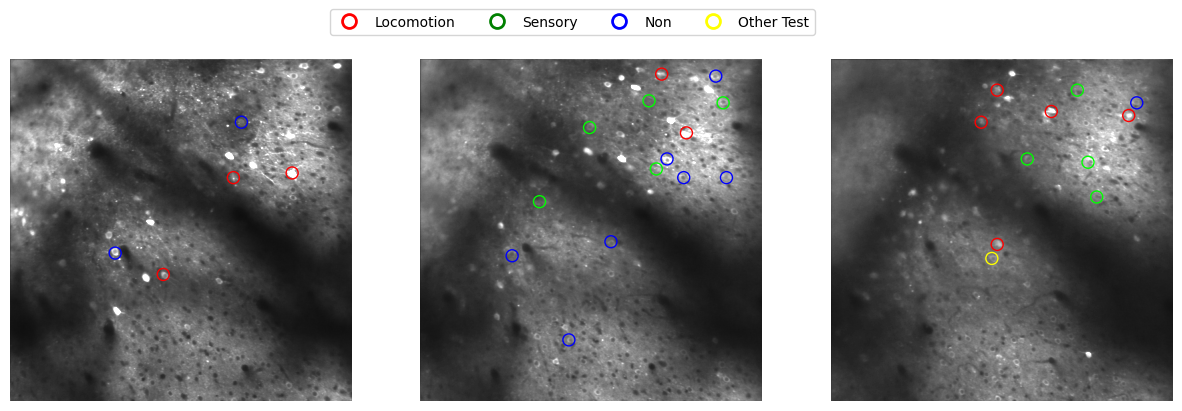

In [220]:
# Convert ETL string to a list of floats
importlib.reload(CB)
fig, axes = CB.multi_planes_2d_show(refImg1, None, FilteredTestPos3D, None, zdepth, colorTarget, img_clim=[0,1000], plot_param=None)

legend_labels = ['Locomotion', 'Sensory', 'Non', 'Other Test']
legend_colors = ['red', 'green', 'blue', 'yellow']

# Create Legend patches using Line2D for circles
legend_patches = [mlines.Line2D([0], [0], color=color, marker='o', linestyle='None', 
                                markersize=10, markeredgewidth=2, fillstyle='none') 
                  for color in legend_colors]
# Add the Legend to the figure
fig.legend(handles=legend_patches, labels=legend_labels, loc='upper center', 
           ncol=len(legend_labels), fontsize=10, bbox_to_anchor=(0.5, 0.95))


save_path = os.path.join(ProcessFolder, "FinalTargets_Suite2p.png")
fig.savefig(save_path, dpi=300, bbox_inches='tight')
save_path = os.path.join(ProcessFolder, "FinalTargets_Suite2p.tif")
fig.savefig(save_path, dpi=300, bbox_inches='tight')
save_path = os.path.join(ProcessFolder, "FinalTargets_Suite2p.svg")
fig.savefig(save_path, dpi=300, bbox_inches='tight')
save_path = os.path.join(ProcessFolder, "FinalTargets_Suite2p.eps")
fig.savefig(save_path, dpi=300, bbox_inches='tight')
# Save the figure before showing
 
plt.show()